- **Important: This Notebook requires GPU access on Google Colab. You can access this notebook using this link: https://colab.research.google.com/drive/1kwsHDaQH6Q41qqHPgLvtYN4t2x9ginn0?usp=sharing** 

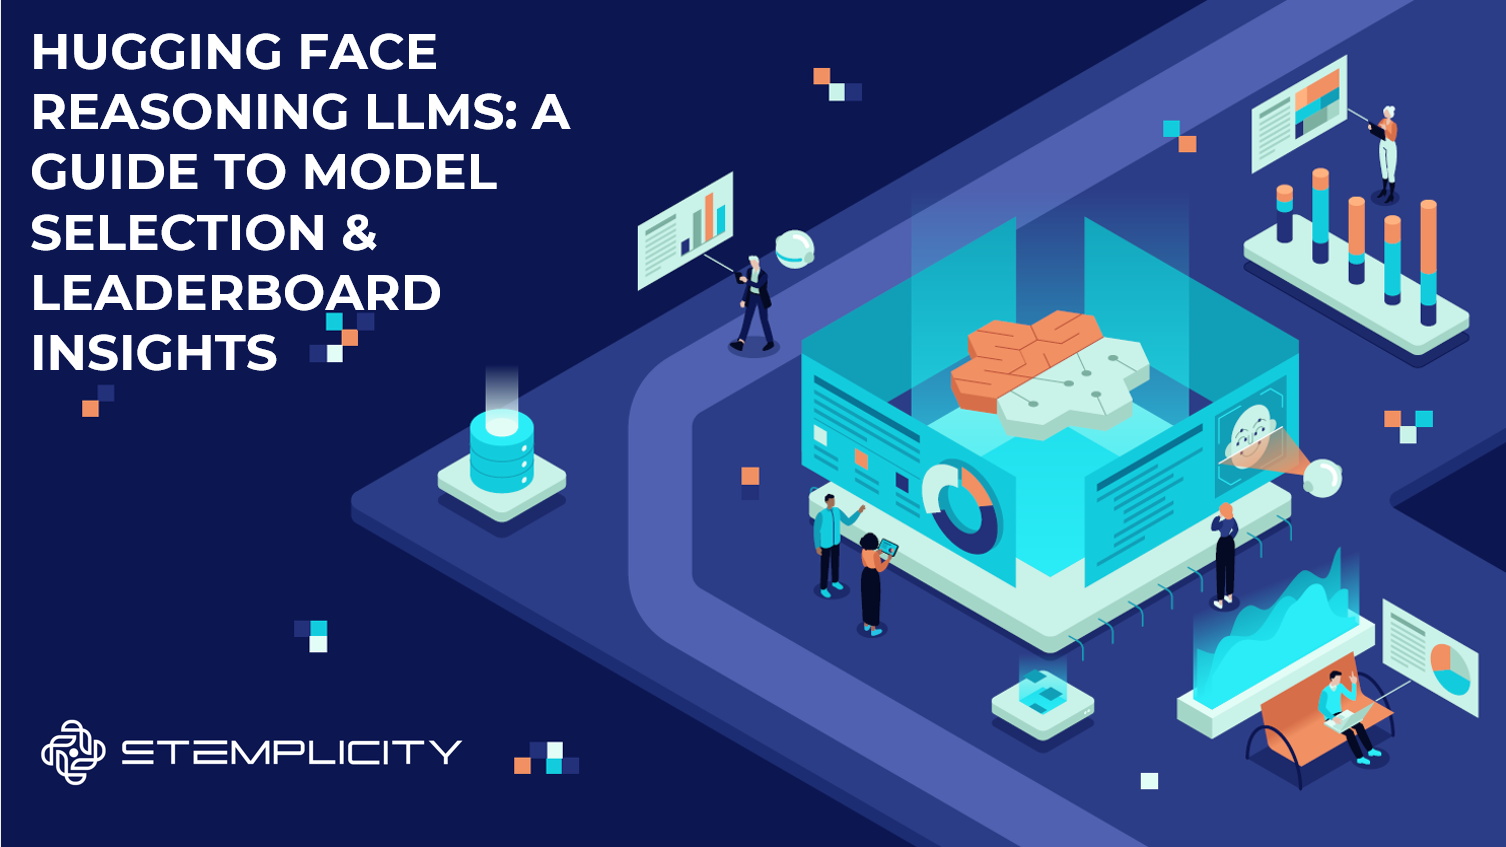

# TASK 1. PROJECT OVERVIEW & KEY LEARNING OBJECTIVES


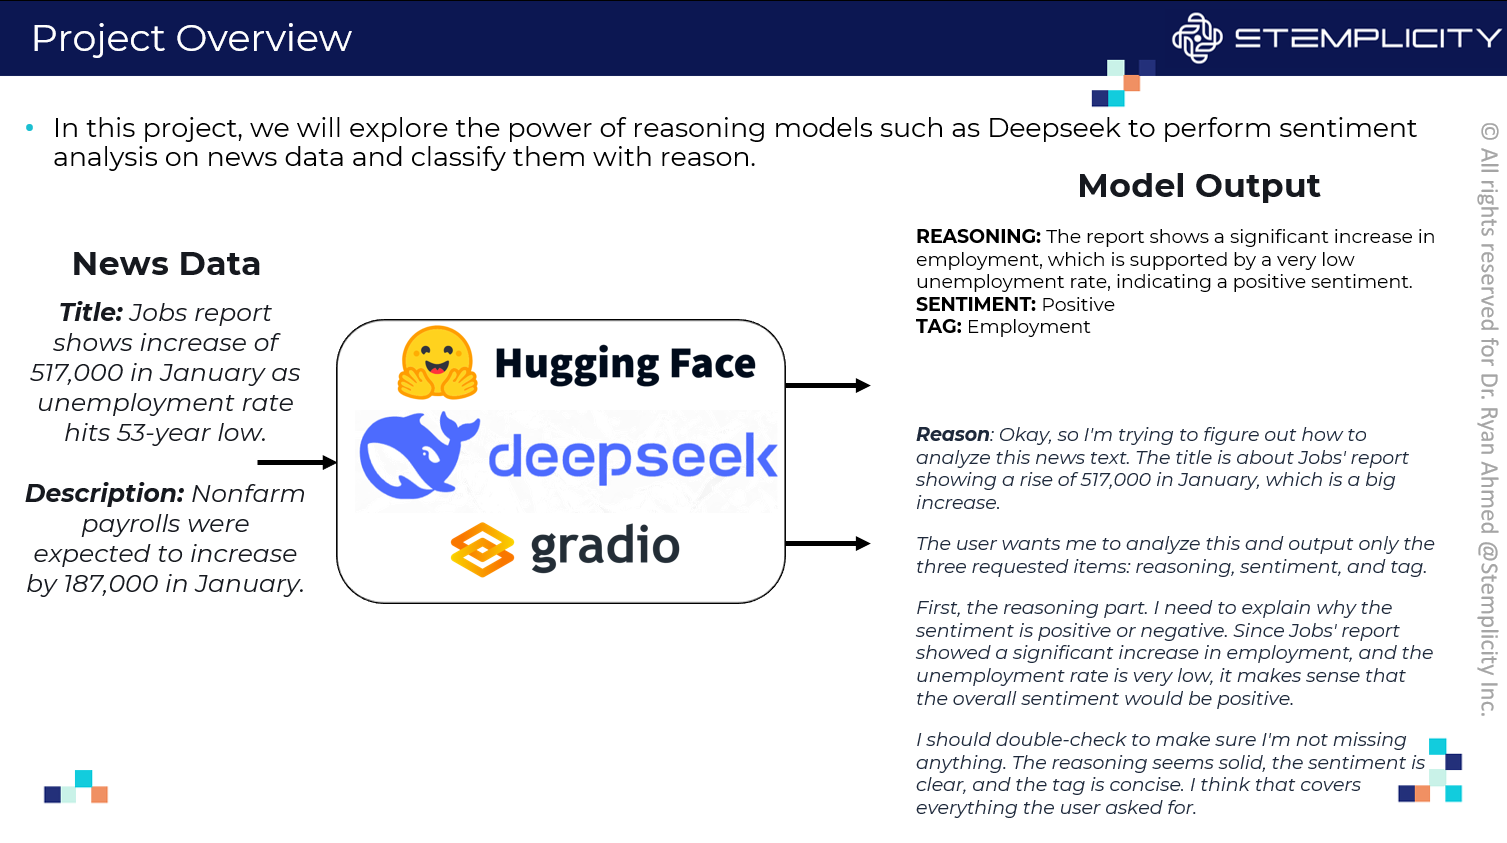

In our previous project, we explored running open-source models for document Q&A. Now, let's dive into models known for stronger **reasoning** capabilities and apply them to a real-world task: analyzing financial news.

We'll use a model from the **DeepSeek** family, known for their strength in coding and instruction following, which often translates to better step-by-step reasoning. We won't just classify news as positive, negative, or neutral; we'll ask the model to explain its reasoning and provide a tag for the news.

**What We'll Build:**

A system that:
1.  Loads financial news headlines and descriptions from a Hugging Face dataset.
2.  Uses a DeepSeek model (like `deepseek-coder-1.3b-instruct`) to analyze the news.
3.  Outputs not just the sentiment classification (Positive, Negative, Neutral) but also a reasoning trace explaining why it reached that conclusion.
4.  Presents this analysis in a simple Gradio interface.




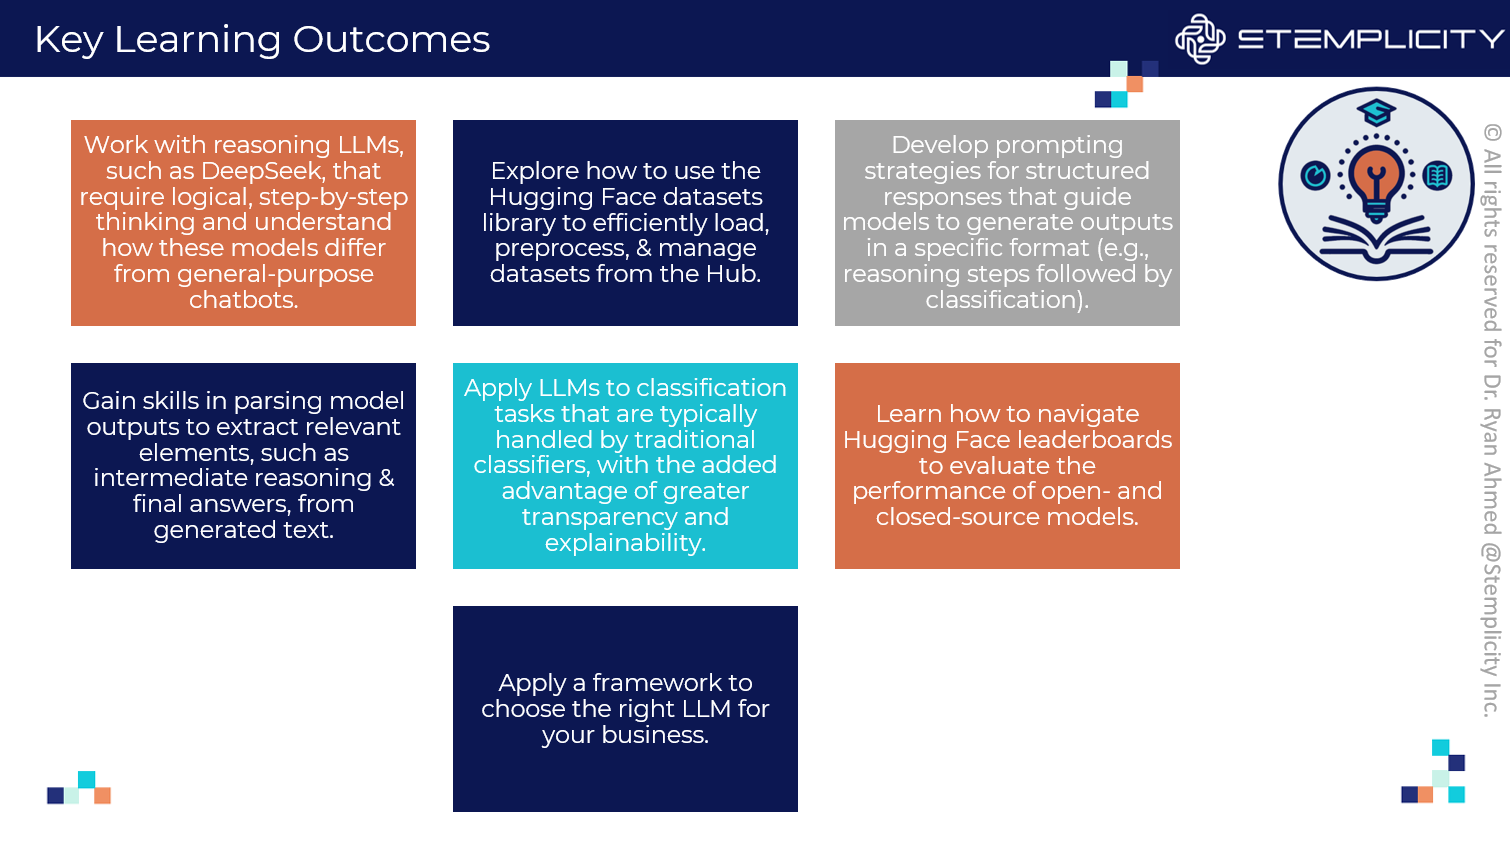

## TASK 2. EXPLORE HUGGING FACE DATASETS LIBRARY & INSTALL KEY LIBRARIES


As usual, we begin by installing the necessary libraries. This time, we're adding the `datasets` library to easily load data from the Hugging Face Hub. We'll also repeat the Hugging Face login step, which is good practice.

**Installing Libraries:**

*   `transformers`, `accelerate`, `bitsandbytes`, `torch`: For loading and running our DeepSeek model efficiently.
*   `datasets`: To load the financial news dataset.
*   `gradio`: For building the UI.

- **Link to Datasets Library on Hugging Face: https://huggingface.co/datasets**

In [ ]:
print("Installing necessary libraries...")

# Transformers: Lets you easily use powerful pre-trained AI models for tasks like text generation, translation, or classification.
# Accelerate: Helps you run and train models efficiently across CPUs, GPUs.
# BitsAndBytes: Reduces the size of large models using quantization so they can fit and run on limited hardware like free GPUs.
# Torch (PyTorch): A deep learning library used to build, train, and run neural networks using tensors and GPU acceleration.

# Added 'datasets' to the list
!pip install -q transformers accelerate bitsandbytes torch datasets gradio

print("Libraries installed successfully!")

In [ ]:
# Hugging Face Login

import os
from huggingface_hub import login, notebook_login

print("Attempting Hugging Face login...")

notebook_login()
print("Login successful (or token already present)!")

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset  # Import the dataset loading function
import gradio as gr
from IPython.display import display, Markdown
import random  # To pick random news items

# Check for GPU availability
if torch.cuda.is_available():
    print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    torch.set_default_device("cuda")
    print("PyTorch default device set to CUDA (GPU).")
else:
    print("WARNING: No GPU detected. Performance will be very slow.")
    print("Go to Runtime > Change runtime type and select GPU.")


In [ ]:
# Helper function for markdown display
def print_markdown(text):
    """Displays text as Markdown."""
    display(Markdown(text))

**PRACTICE OPPORTUNITY:**
- **Explore the datasets section on Hugging Face, How many datasets are present?**
- **Search for News-related data, which one is the most downloaded?**
- **Search for `all_news_finance_sm_1h2023` dataset. How many samples exist?**
- **Visit the Data Studio and using AI Query Feature, select only news released by CNBC.**

# TASK 3. LOAD FINANCIAL NEWS DATASETS FROM HUGGING FACE


We'll use the Hugging Face `datasets` library to load the `PaulAdversarial/all_news_finance_sm_1h2023` dataset directly from the Hub. This library makes accessing and manipulating large datasets incredibly convenient.

**Steps:**
1.  Use `load_dataset("dataset_name")` to download and cache the dataset.
2.  Inspect the dataset structure and features (columns).
3.  Select the relevant columns ('title' and 'description') for our analysis.
4.  Combine the title and description into a single text input for the LLM.


In [ ]:
dataset_id = "PaulAdversarial/all_news_finance_sm_1h2023"

print(f"Loading dataset: {dataset_id}...")

# Load the dataset (will download if not cached)
# We might only need the 'train' split, specify split = 'train' if needed
# The datatype of news_dataset is datasets.Dataset (from the datasets library by Hugging Face).
news_dataset = load_dataset(dataset_id, split = "train")
print("Dataset loaded successfully!")


In [ ]:
# Let's Inspect the dataset
news_dataset

In [ ]:
# Let's display the features (columns and their types)
print("\n Dataset Features")
print(news_dataset.features)

In [ ]:
# Let's view the datasets as a Pandas DataFrame
news_dataset.to_pandas()

In [ ]:
# Let's prepare the data for the LLM
# We'll combine title and description for the input text
def combine_news_text(example):

    # Handle potential None values gracefully
    title = example.get("title", "") or ""
    description = example.get("description", "") or ""

    # Add a separator for clarity
    return {"full_text": f"Title: {title}\nDescription: {description}"}


In [ ]:
# Let's apply the function to combine the 'title' and 'description' into 'full_text'
# This uses map, which is efficient for datasets

news_dataset = news_dataset.map(combine_news_text)

print("\n--- Sample Data with 'full_text' ---")
print(news_dataset[0])

In [ ]:
# Let's display the full_text of the first sample
print(news_dataset[0]["full_text"])

**PRACTICE OPPORTUNITY:**
- **Examine the "Dataset Features" output. Besides 'title' and 'description', what other potentially interesting columns are available (e.g., `main_domain`, `created_at`)?**
- **Modify the `display(...)` line in the code block to show 10 samples. Rerun the cell. Do the titles and descriptions seem relevant to financial news?**
- **How would you access only the `full_text` of the 100th news item in the dataset?**


# TASK 4. LOAD & TEST DEEPSEEK REASONING MODEL


Now, let's load our chosen "reasoning" model. We're using `deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B` which excels at following complex instructions and performing logical steps, which is useful for our task of generating a reasoned sentiment analysis.

**Why DeepSeek for this Task?**
*   **Instruction Following:** Good at adhering to complex prompts, like our request for both reasoning and classification in a specific format.
*   **Logical Steps:** Its training helps in breaking down the analysis into steps (the reasoning trace).
*   **Colab Friendly:** The 1.5B parameter size is manageable within the free tier GPU memory limits when using 4-bit quantization.

We'll load it using the same `transformers` components (`AutoTokenizer`, `AutoModelForCausalLM`, `pipeline`) and 4-bit quantization (`load_in_4bit=True`) as in the previous project.


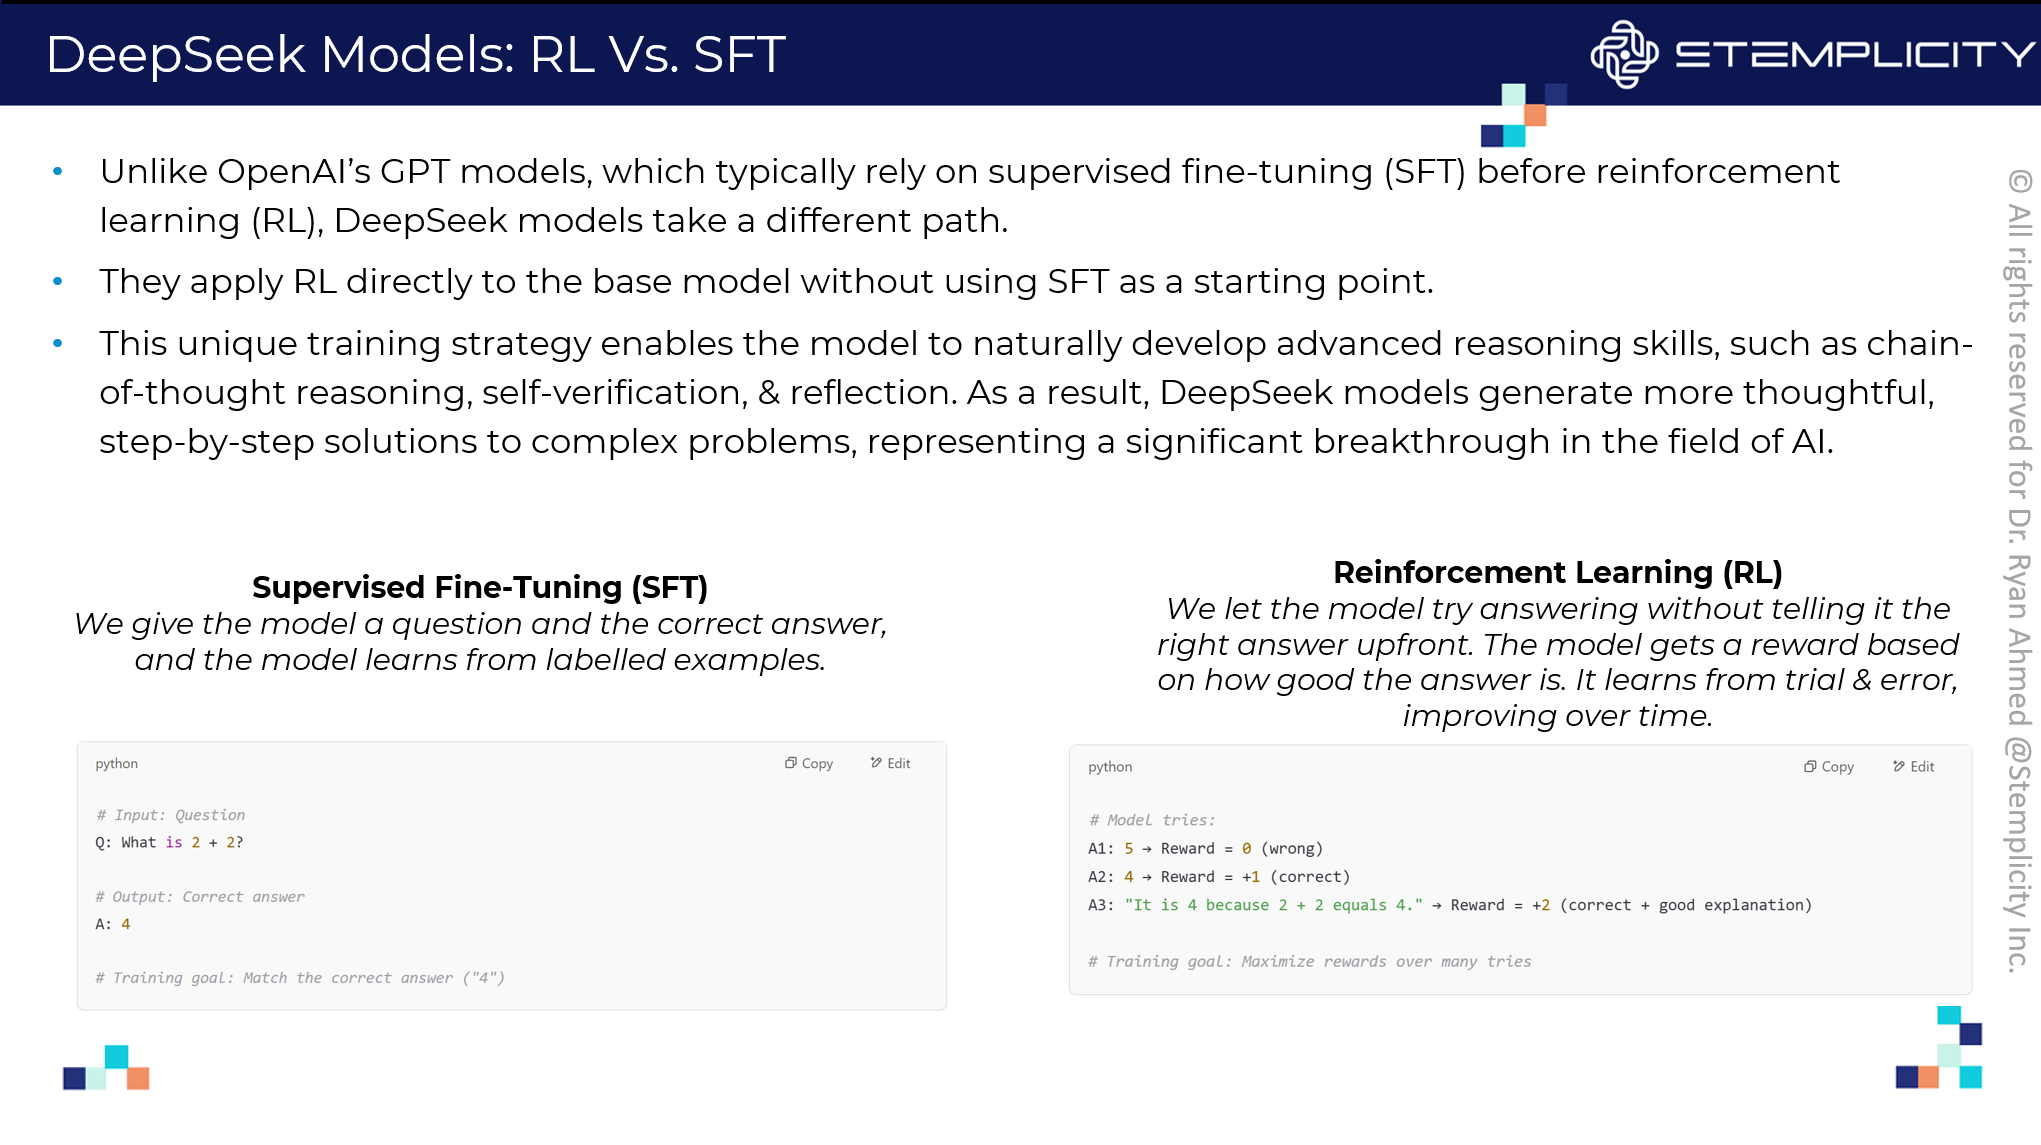

Let's explore the model: https://huggingface.co/deepseek-ai/deepseek-coder-1.3b-instruct

In [ ]:
# Let's choose our smaller DeepSeek model, which is suitable for Google Colab and reasoning tasks.
model_id = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
print(f"Loading model: {model_id}")
print("This may take a few minutes...")


# AutoModelForCausalLM.from_pretrained(...): Loads a pre-trained language model for tasks like text generation (e.g., ChatGPT-like behavior).
# model_id: The name or path of the model you want to load from Hugging Face (like "meta-llama/Llama-3-8b").
# torch_dtype="auto": Automatically chooses the best data type (like float16 or float32) based on your hardware for efficiency.
# load_in_4bit=True: Loads the model in 4-bit precision to save memory and run on limited hardware like free Colab GPUs.
# device_map="auto": Automatically puts the model on the right device (GPU if available, otherwise CPU).
# trust_remote_code=True: Use only with trusted models to avoid security risks.

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype = "auto",
                                             load_in_4bit = True,
                                             device_map = "auto",
                                             trust_remote_code = True)

model.eval()
print("Model loaded successfully in 4-bit!")

In [ ]:
# Let's load the Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code = True)
print("Tokenizer loaded successfully.")

In [ ]:
# Let's create the Text Generation Pipeline
llm_pipeline = pipeline("text-generation", model = model, tokenizer = tokenizer, torch_dtype = "auto", device_map = "auto")
print("Text generation pipeline created successfully.")

In [ ]:
# Let's build the full formatted prompt:
# <|im_start|>user: Marks the beginning of the user's message.
# {test_question}: Inserts your question.
# <|im_end|>: Marks the end of the user’s message.
# <|im_start|>assistant: Signals that the assistant (AI) is about to reply.
# <think>: Encourages the AI to generate internal reasoning or thoughts before answering.

test_question = "Explain what electric cars are in simple terms. Keep the thinking short."
test_prompt = f"<|im_start|>user\n{test_question}<|im_end|>\n<|im_start|>assistant\n<think>\n"
print(f"Test prompt:\n{test_prompt}")

In [ ]:
# Let's test this beast of a model!
# Generate text using the pipeline
# max_new_tokens: Maximum number of tokens to generate
# do_sample: Enable sampling for more diverse outputs (vs greedy decoding). Enables sampling, meaning the model won’t always pick the highest probability next word — instead, it adds some randomness to make responses more creative and diverse.
# temperature: Controls randomness (0.7 is balanced between creative and focused)
# top_p: Nucleus sampling parameter (0.9 keeps responses on topic while allowing variety). Where the model chooses from the top 90% of likely next words (not just the top one). Helps keep output fluent but varied.

print("Testing model with a simple instruction")

outputs = llm_pipeline(test_prompt,
                       max_new_tokens = 4000,
                       do_sample = True,
                       temperature = 0.7,
                       top_p = 0.9)

outputs

In [ ]:
# Function to extract and format the reason and output
def format_model_output(output):

    # Extract the content within <think> tags as Reason
    reason_start = output.find("<think>") + len("<think>")
    reason_end = output.find("</think>")
    reason = output[reason_start:reason_end].strip()

    # Extract the content after </think> as Output
    output_start = reason_end + len("</think>")
    model_output_content = output[output_start:].strip()

    # Format the result
    reason = f"**Reason**:\n{reason}\n"
    output = f"**Output**:\n{model_output_content}"
    return reason, output

In [ ]:
# Extract and print the generated text (only the response part)
full_output = outputs[0]["generated_text"]
reason, output = format_model_output(full_output)
print_markdown(reason + output)

**PRACTICE OPPORTUNITY:**
- **Try a very simple logic or math problem:**
    ```python
    test_question = "What is the count of apples i have now, if i initially had 5 apples with me and then gave 2 to my Mom and 2 to my brother. Keep the thining short."
```
- **Based on this simple test and the model's description, how might generating a reasoned explanation for sentiment analysis differ from just getting a conversational reply from a general chat model like we used in previous projects? What capabilities of DeepSeek R1 seem useful here?**

# TASK 5. A FRAMEWORK FOR CHOOSING THE RIGHT MODEL FOR YOUR BUSINESS

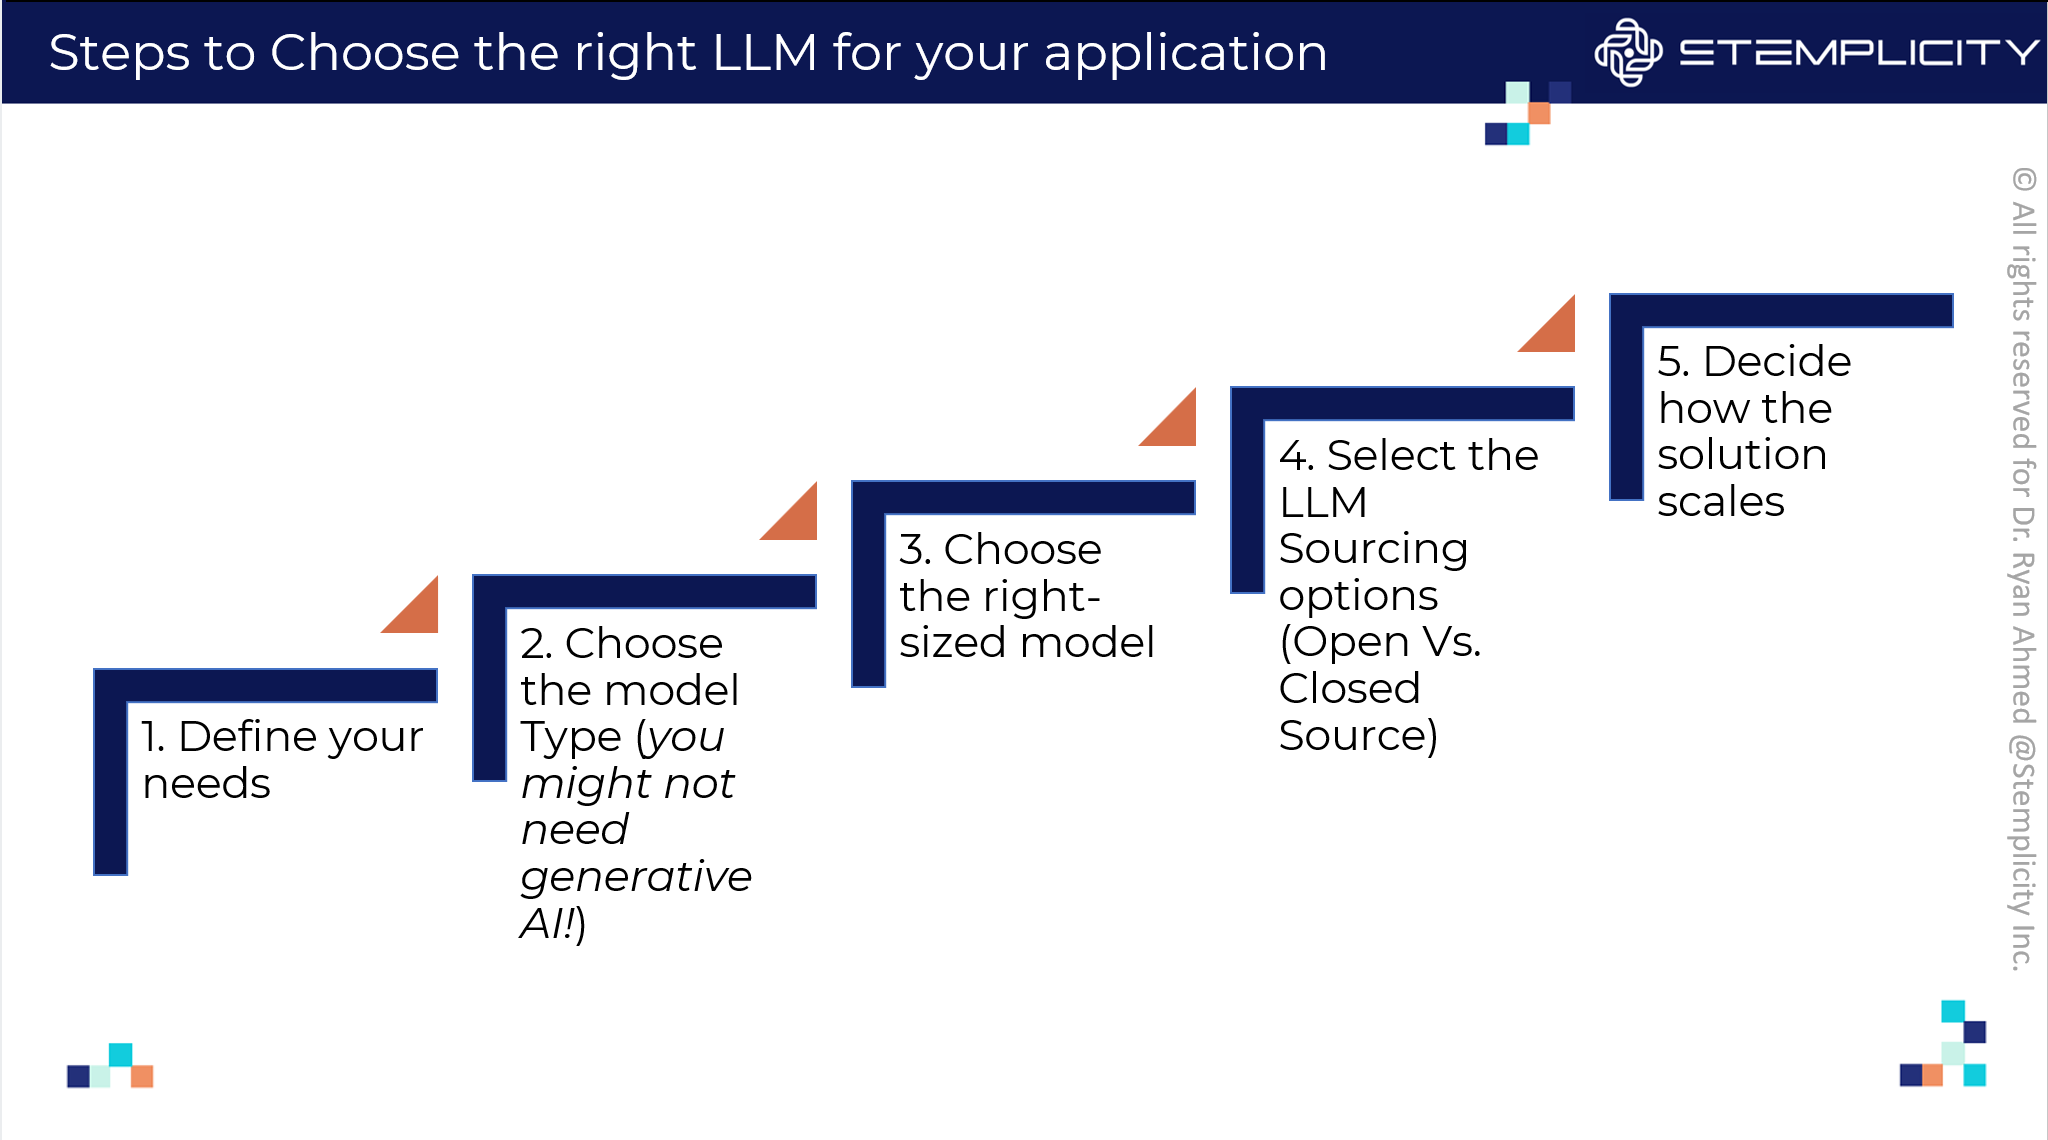

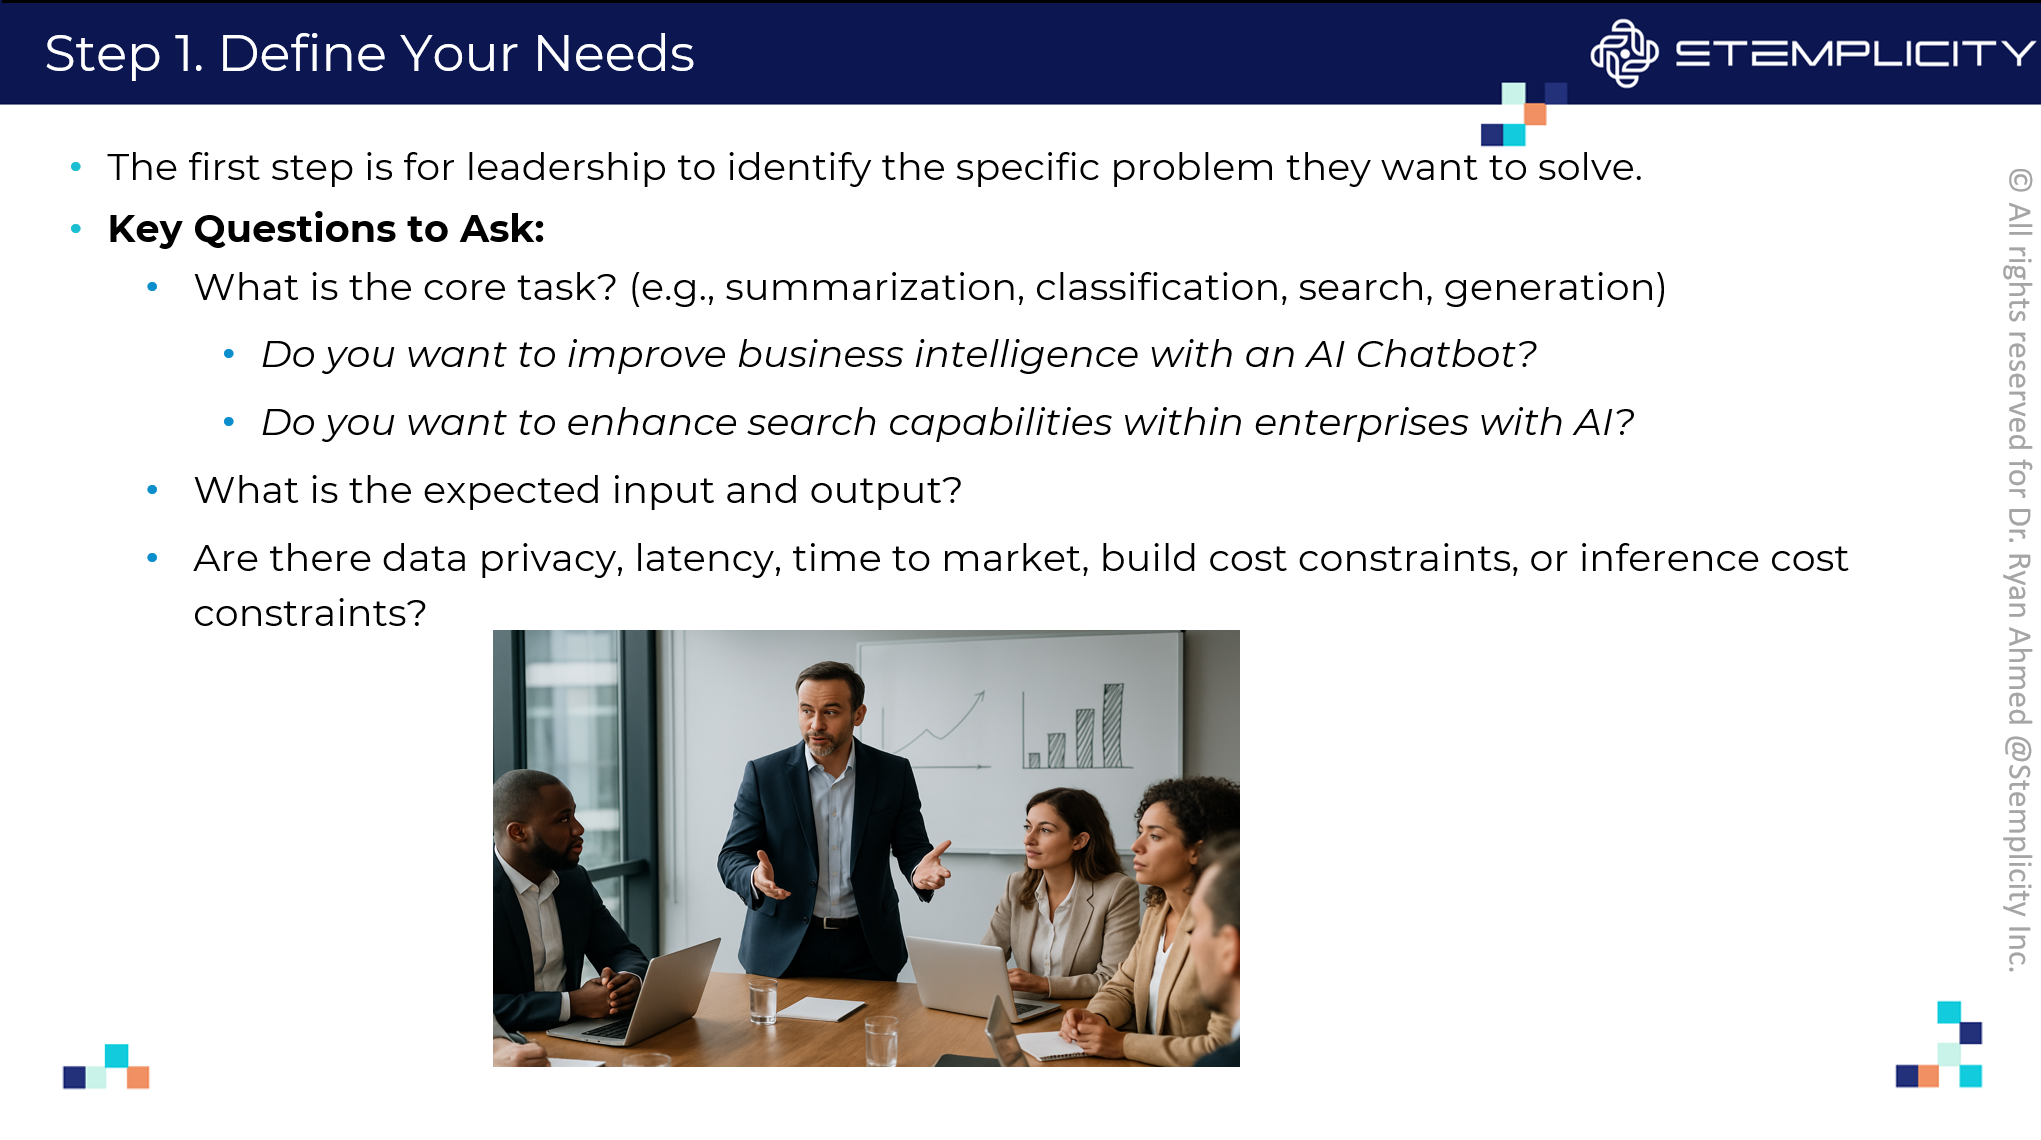

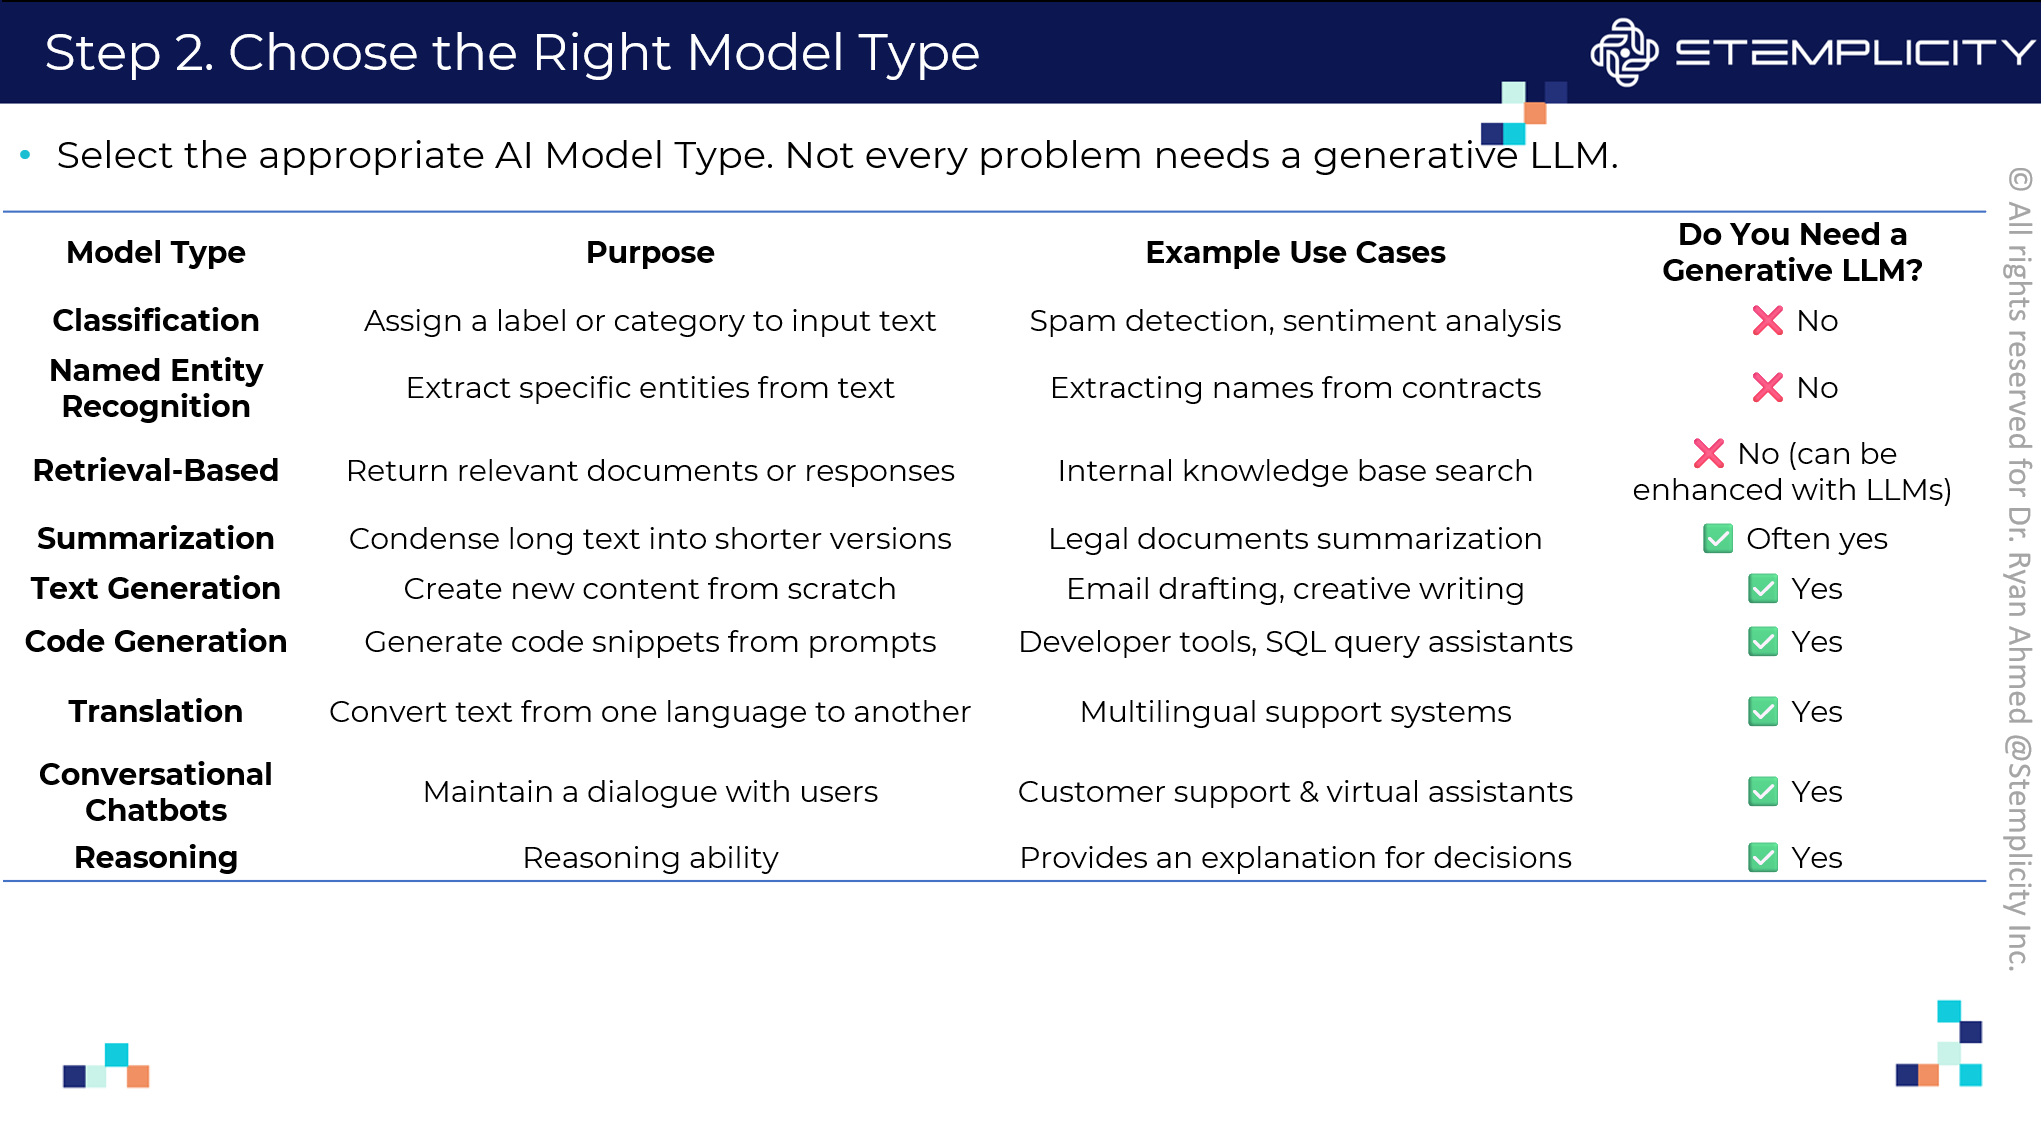

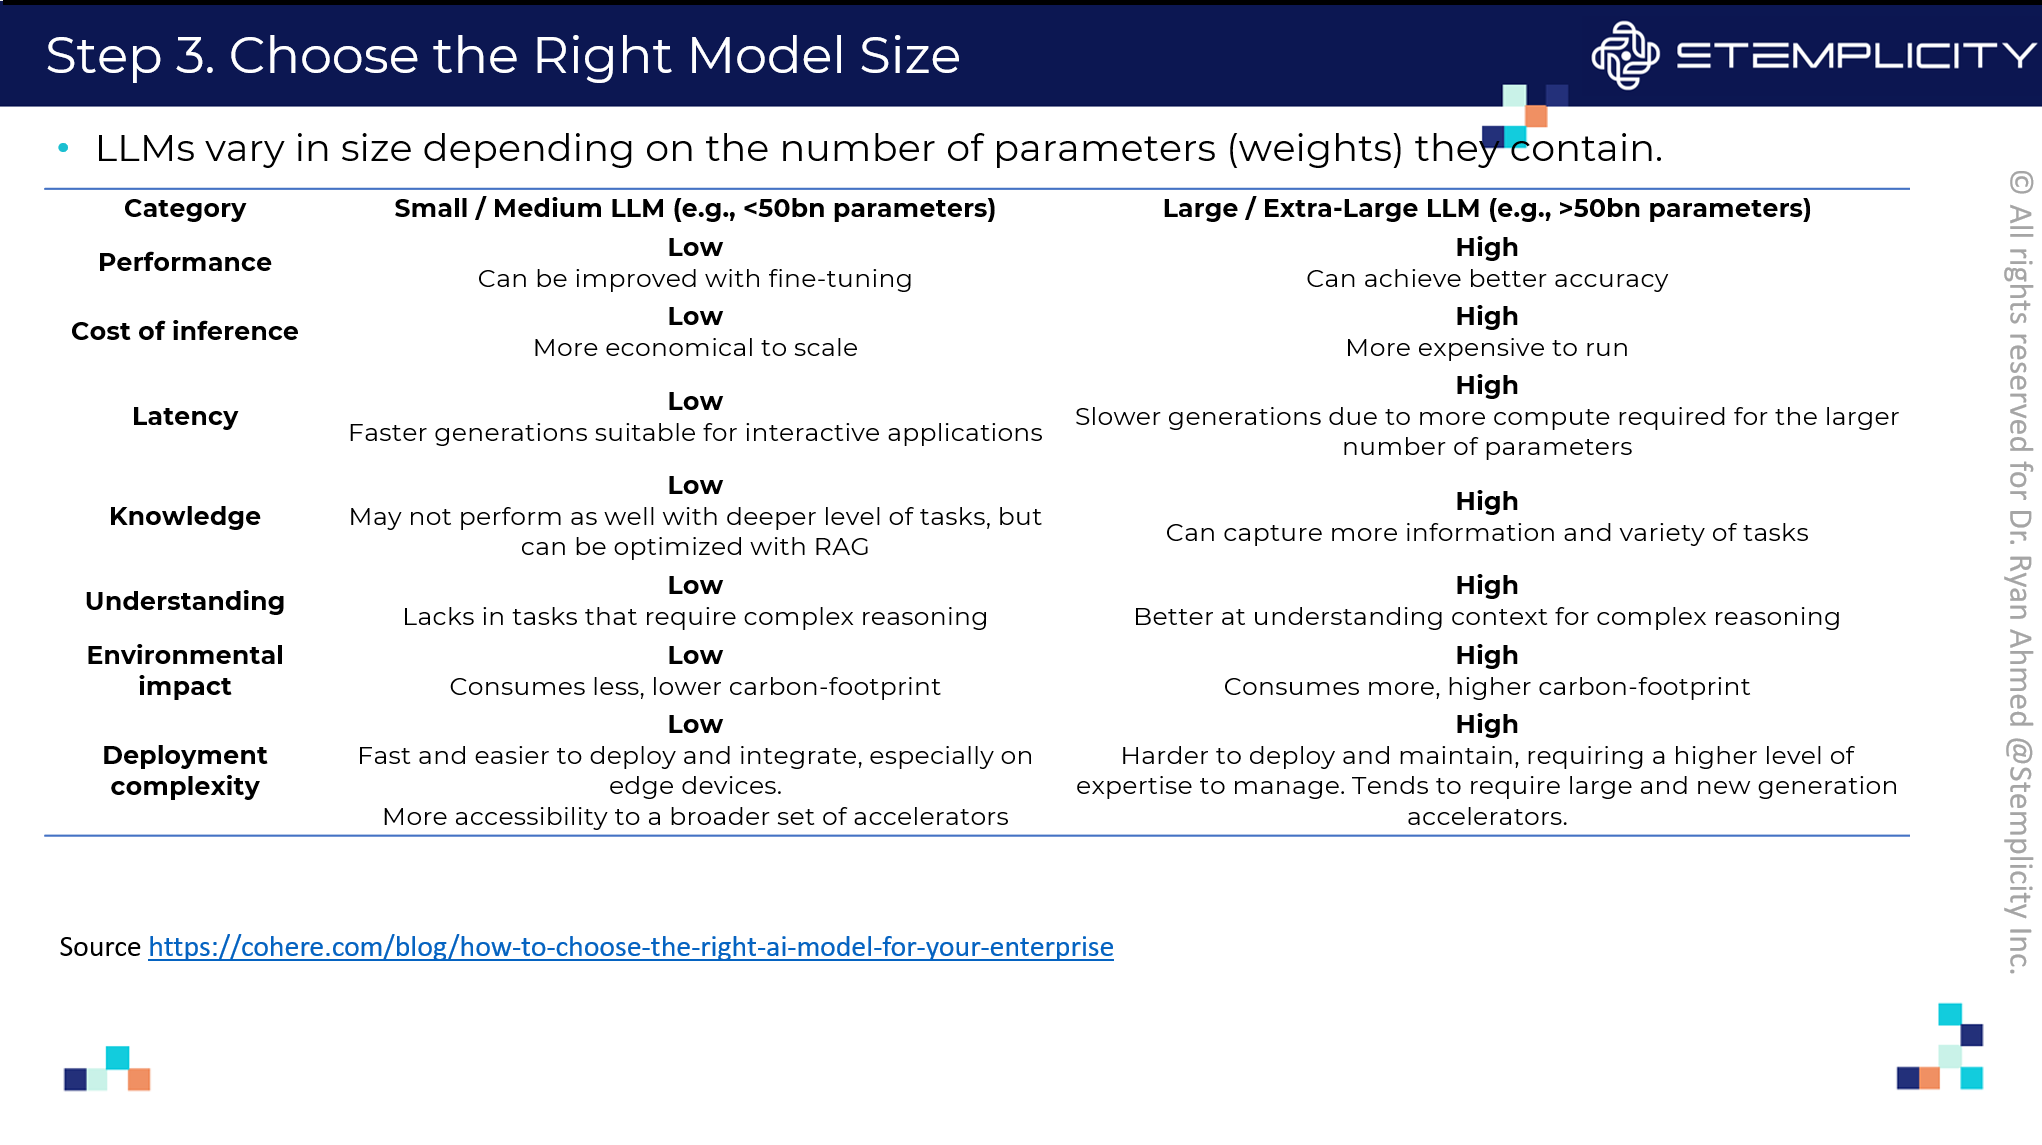

Google Tensorflow Playground: https://playground.tensorflow.org/

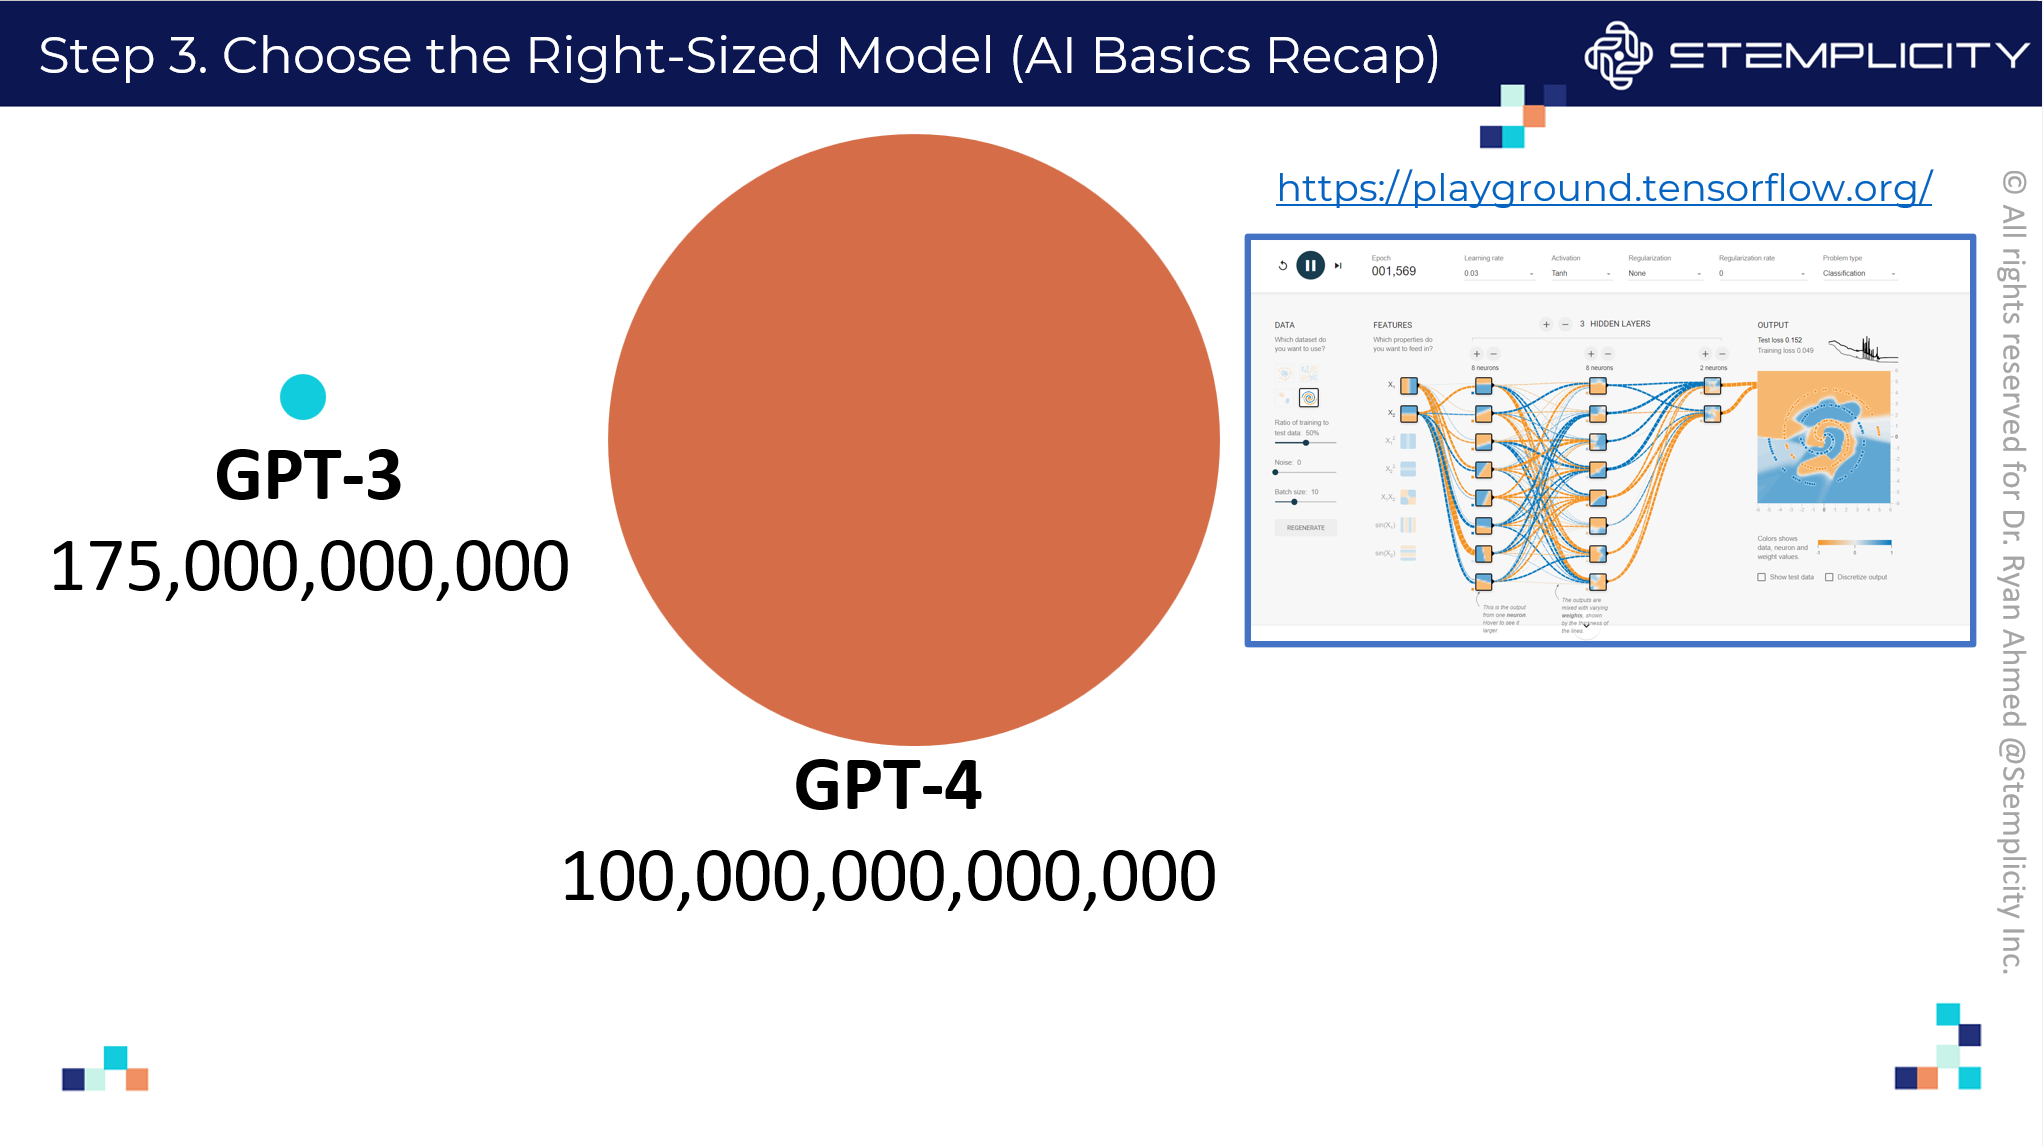

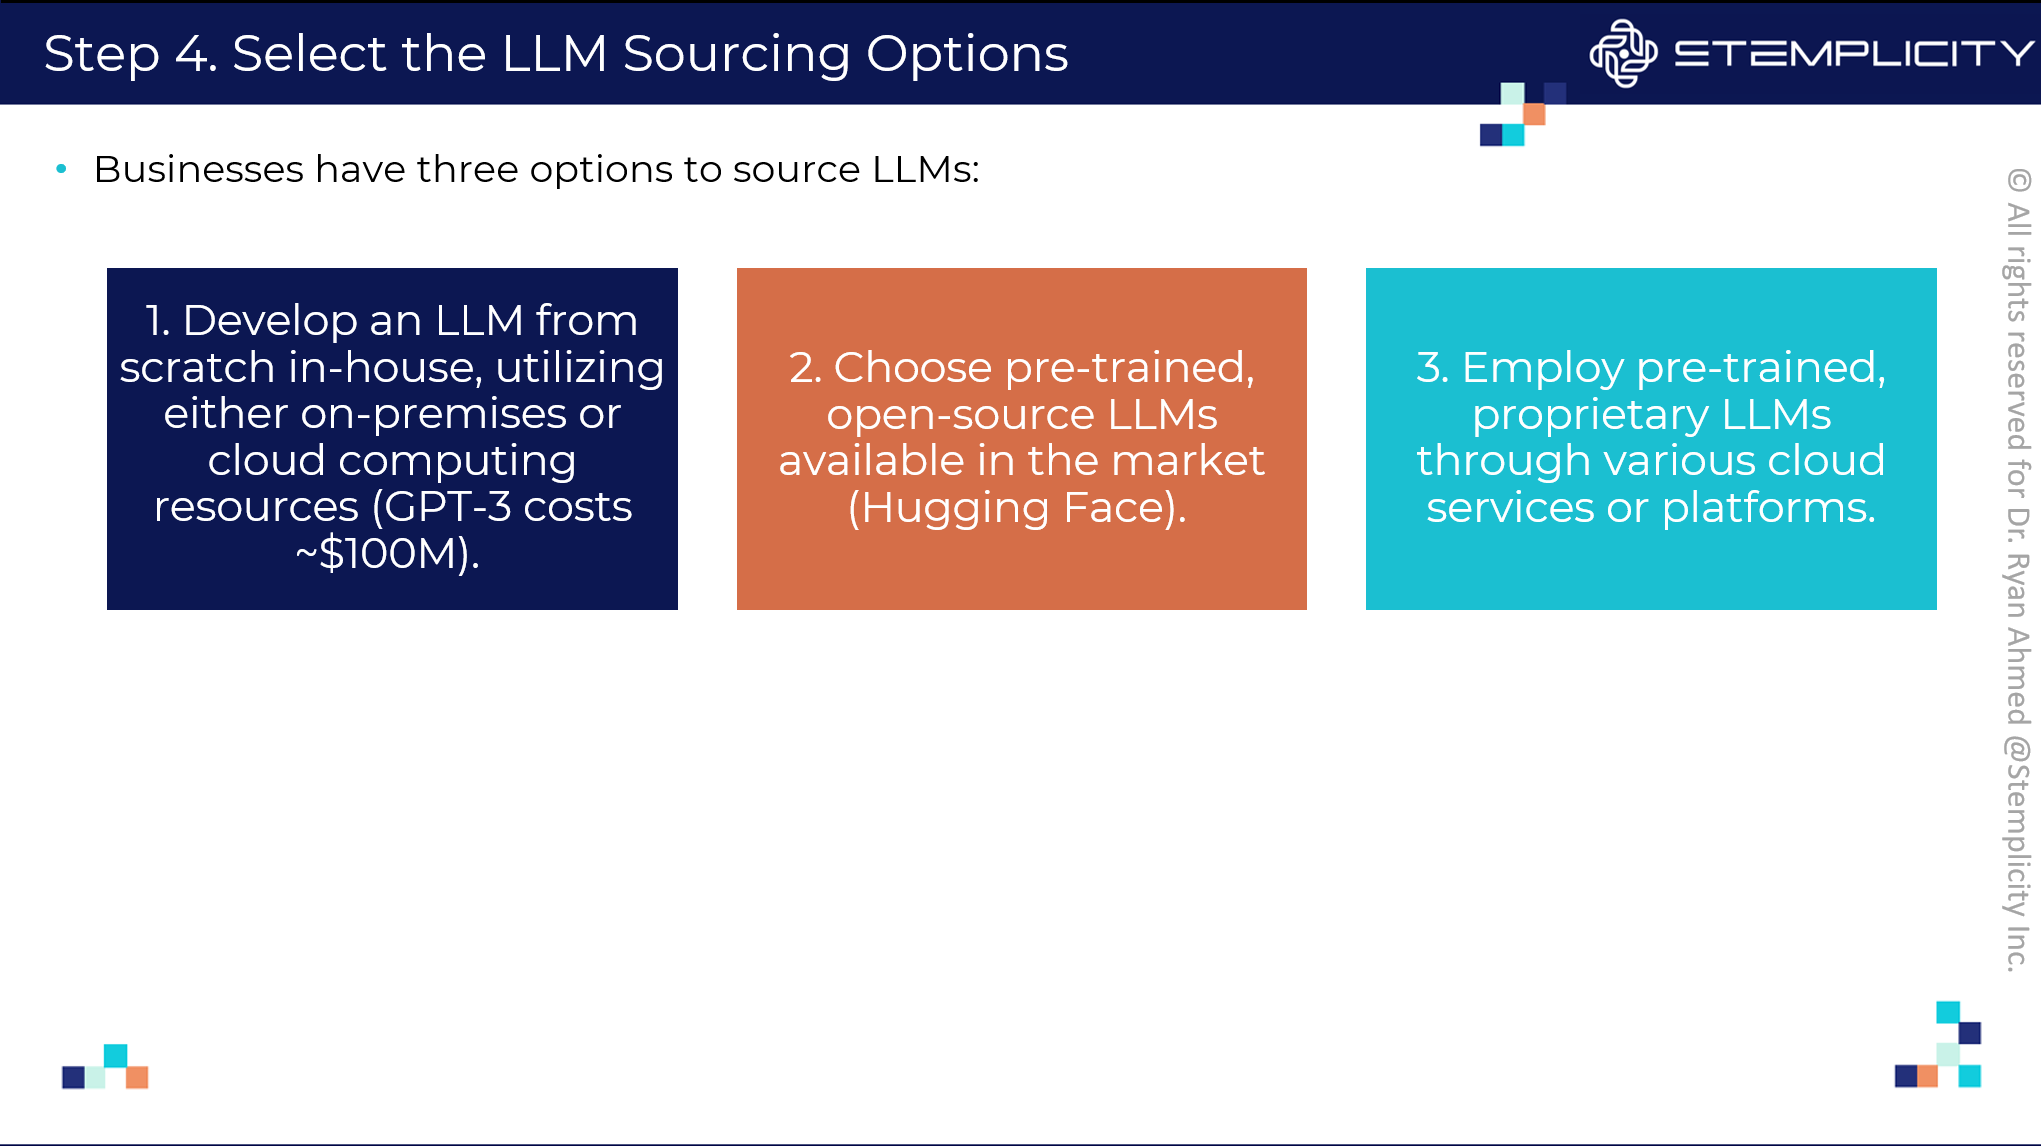

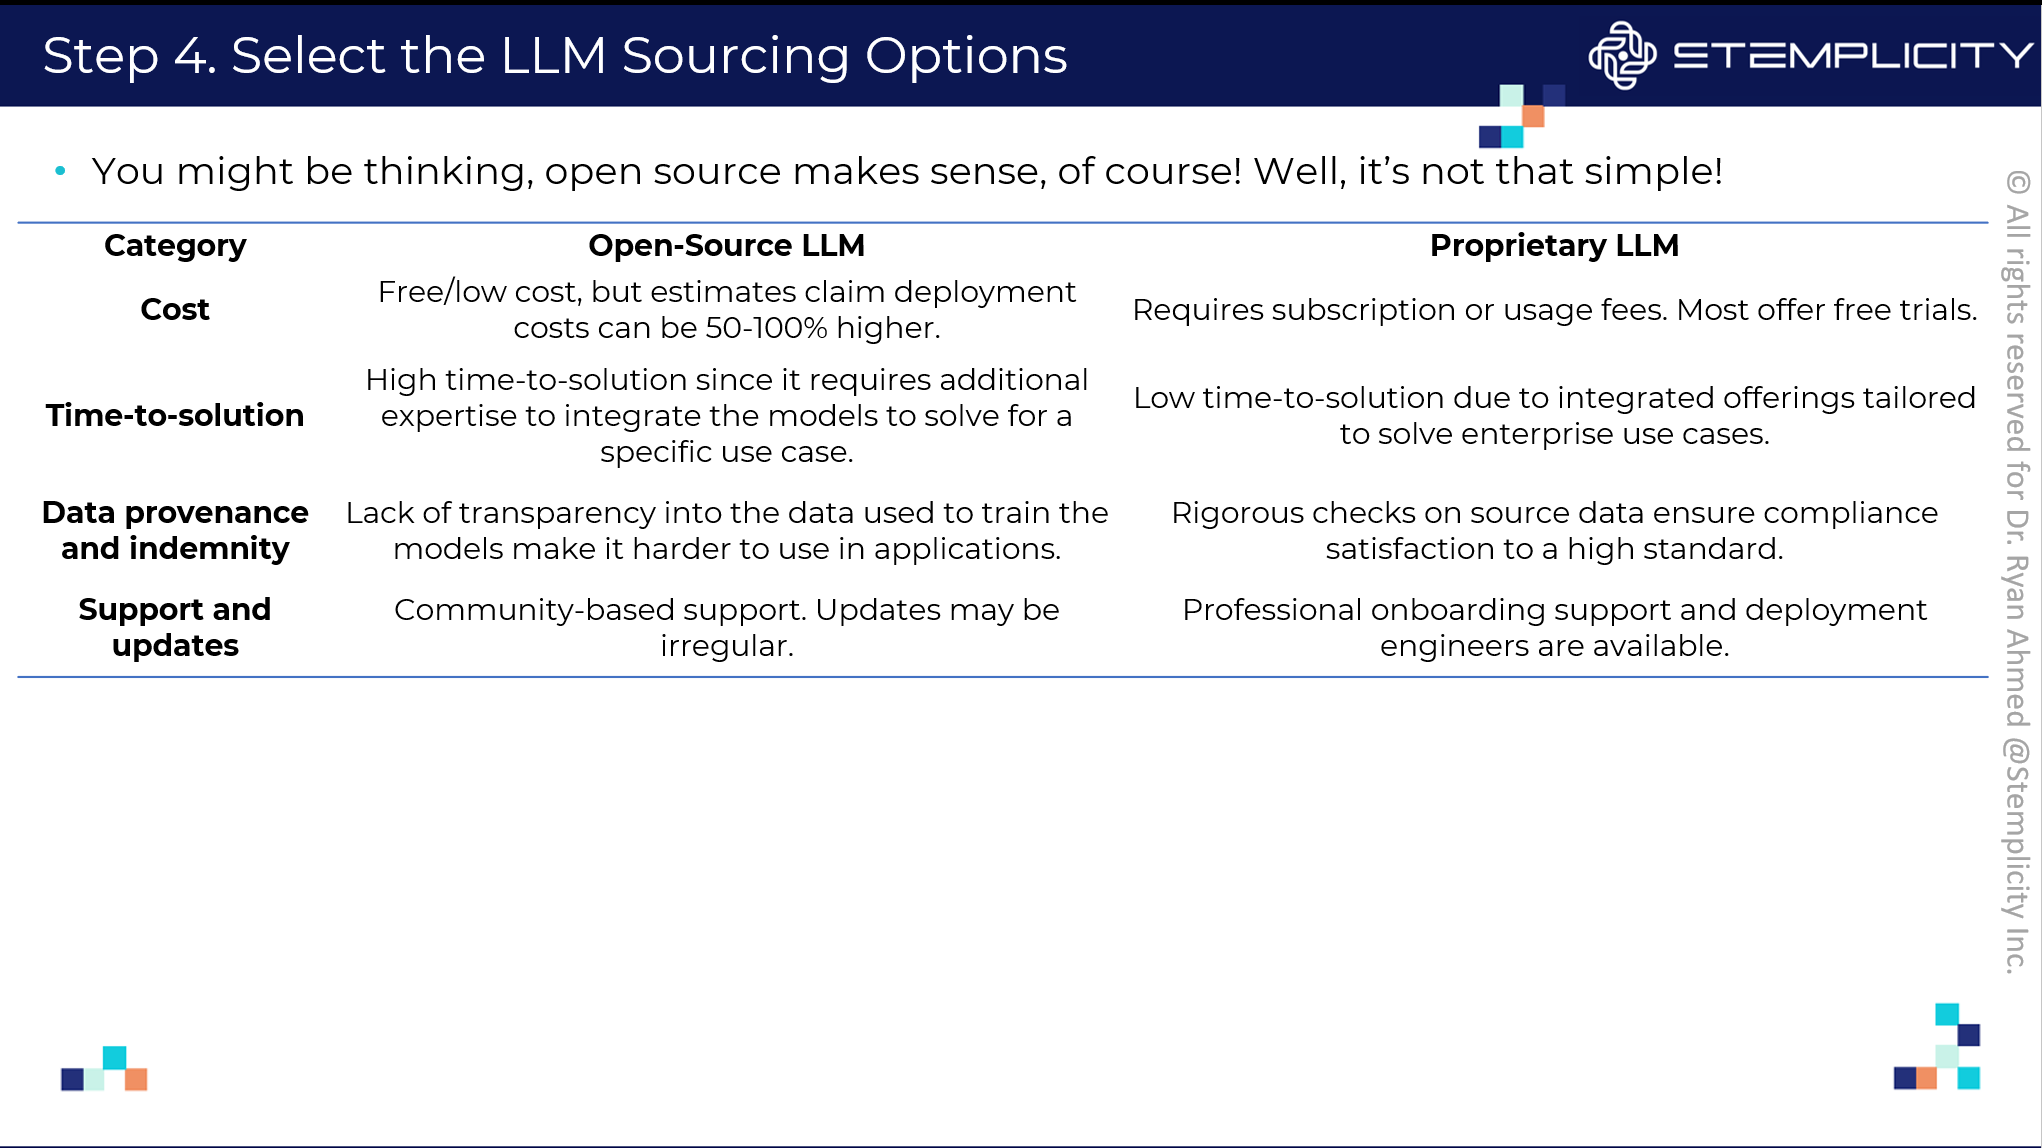

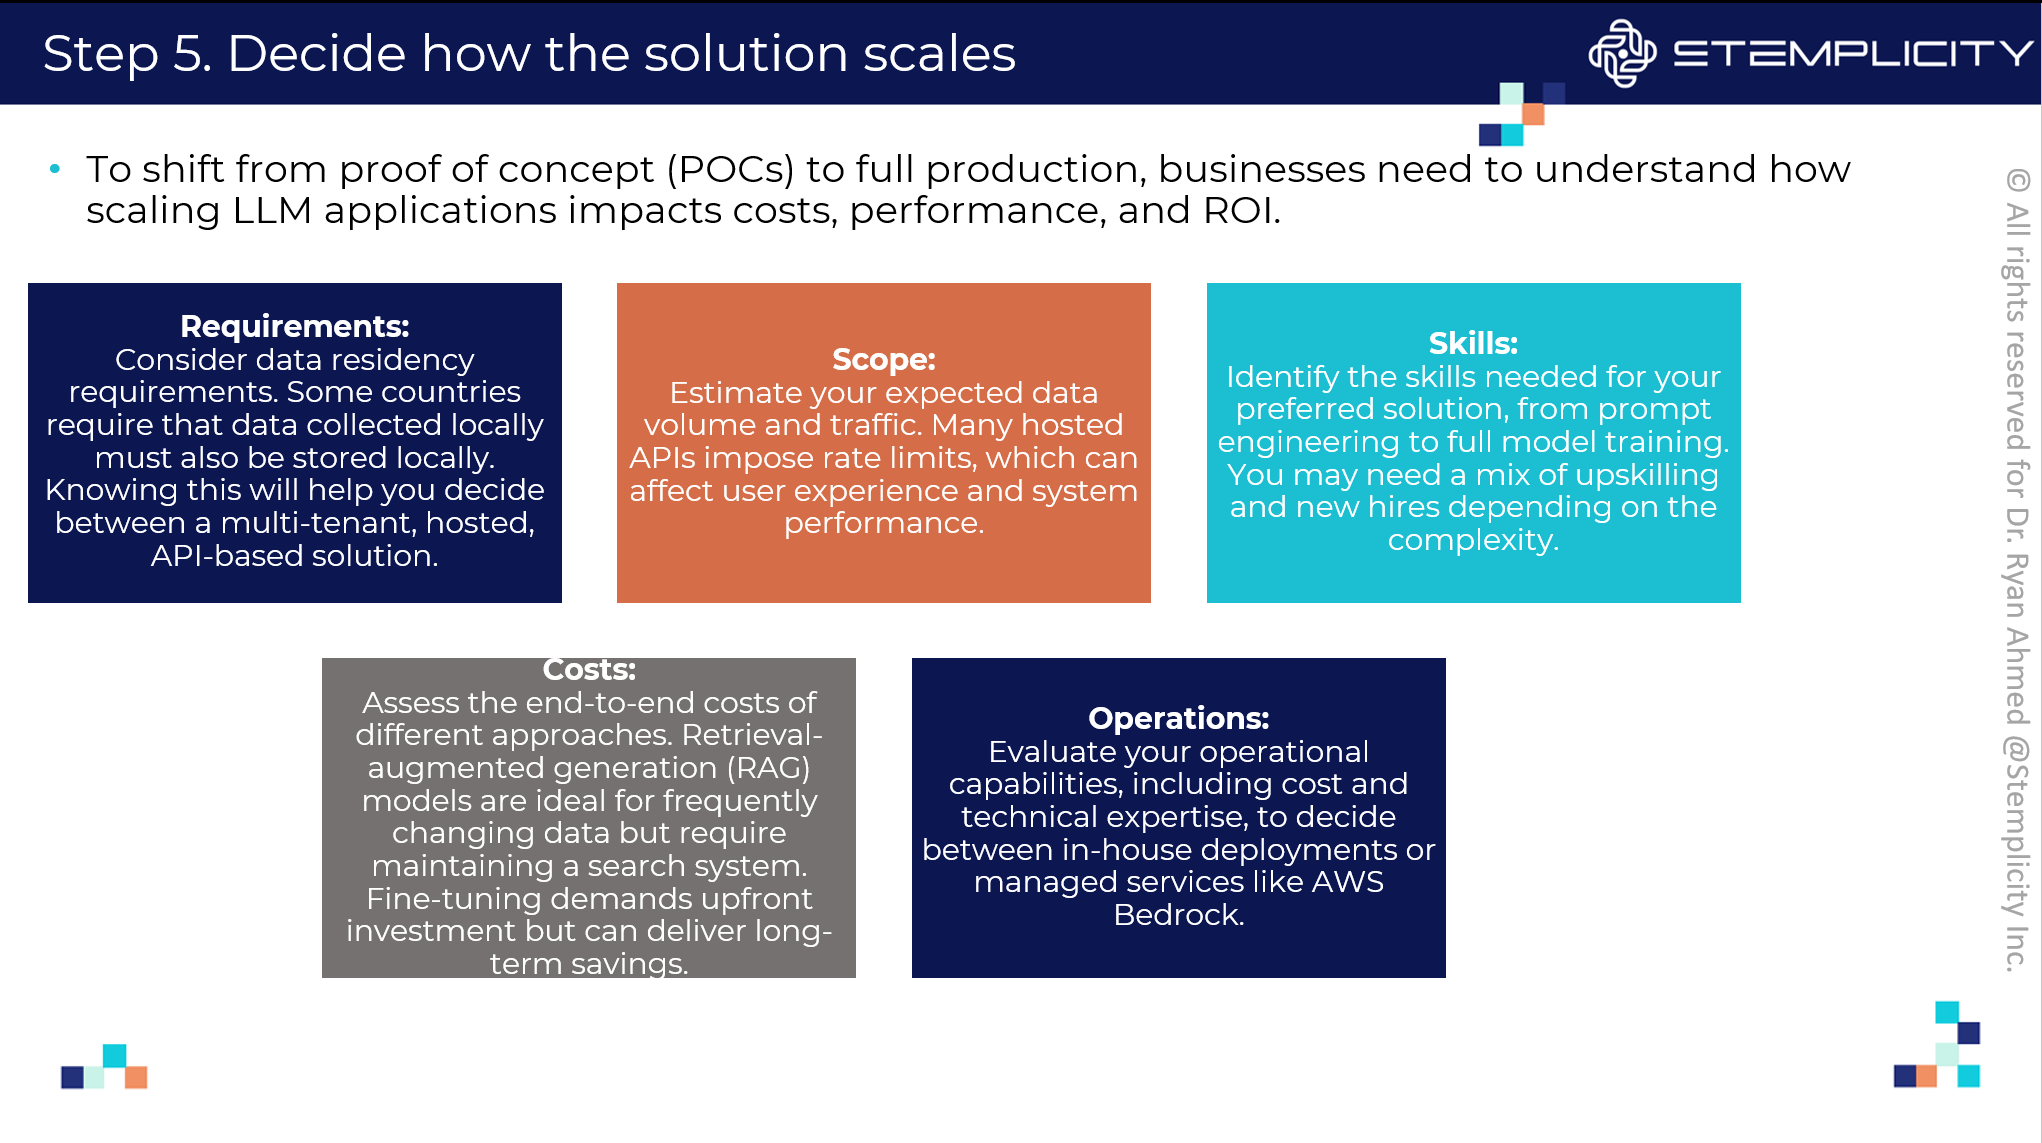

# TASK 6. MODEL LEADERBOARDS & OLD/NEW BENCHMARKS

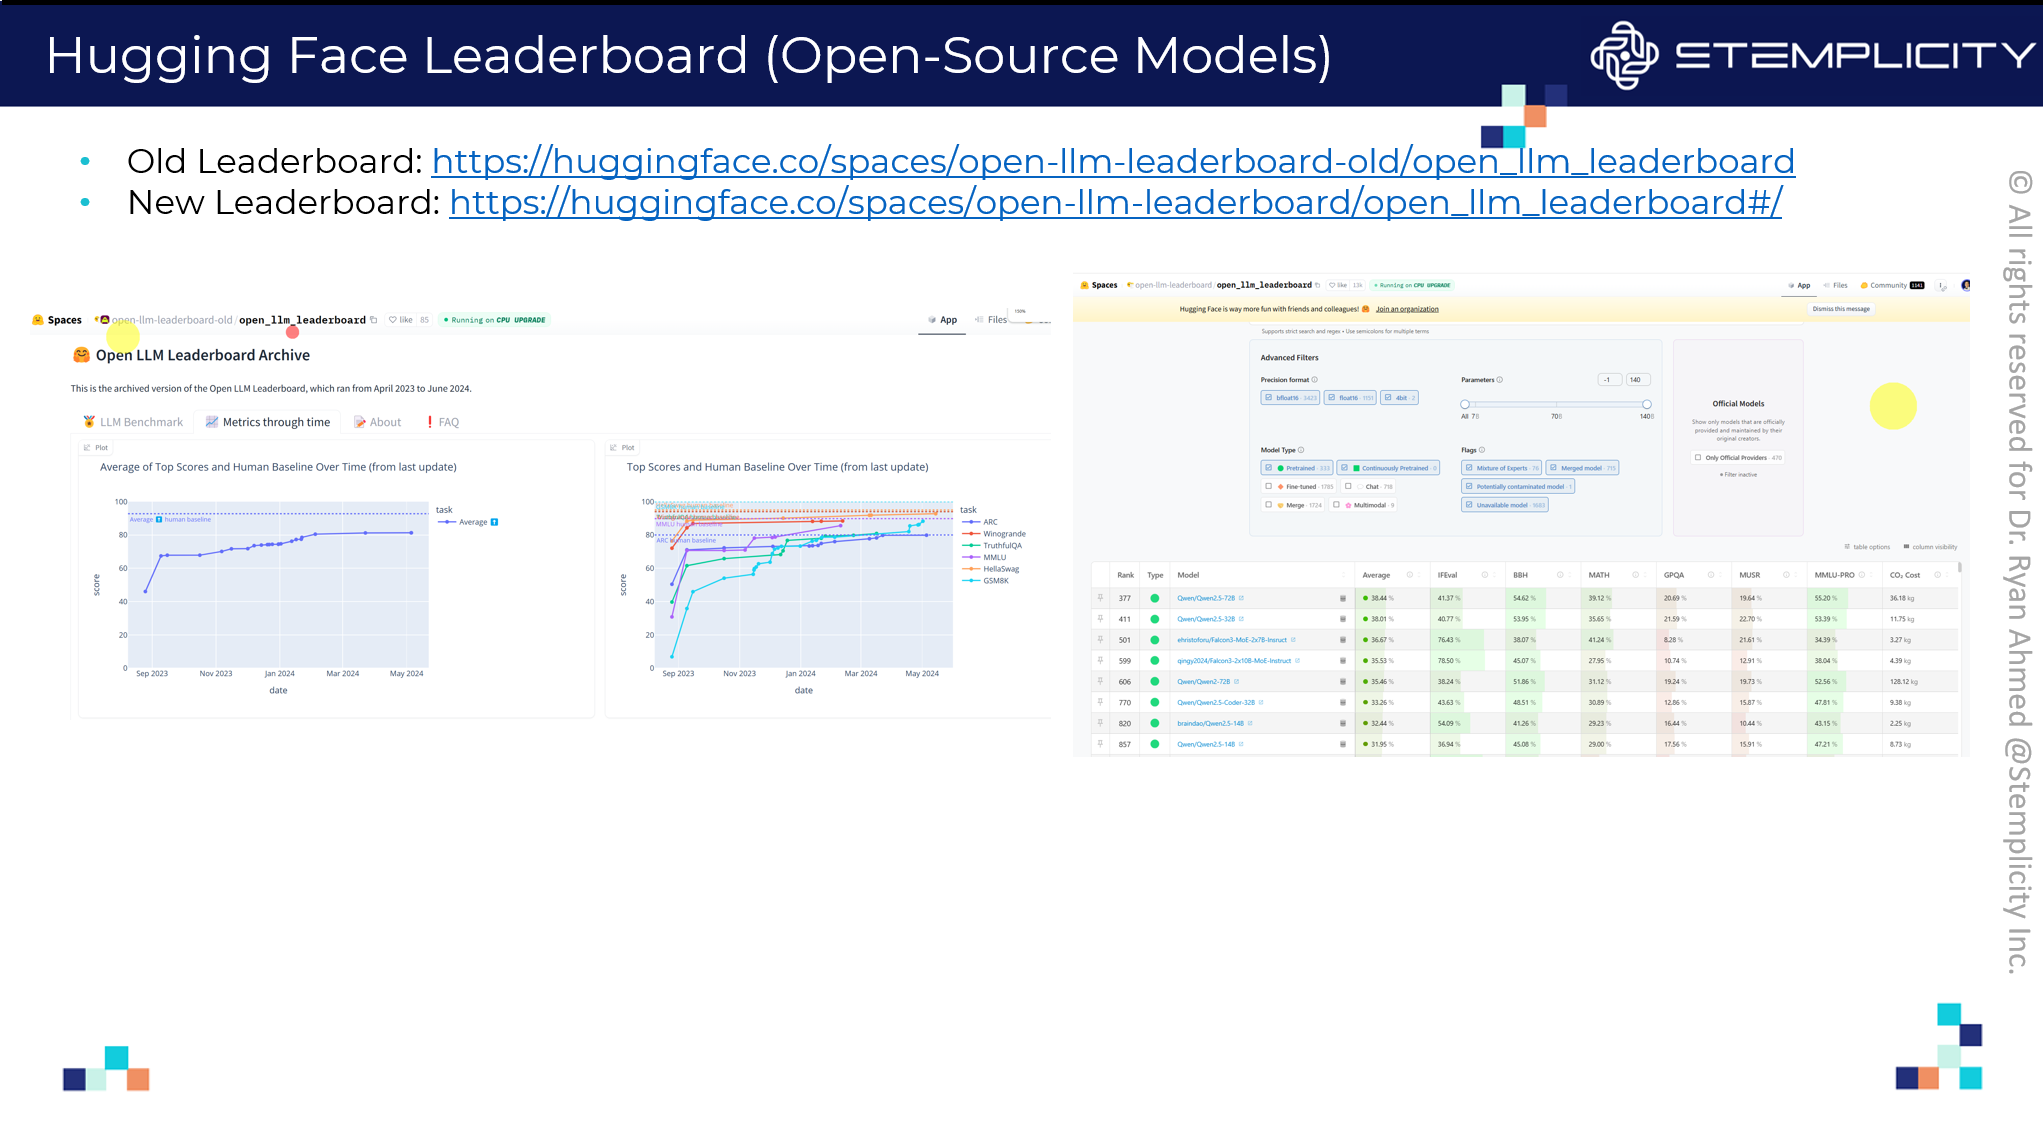

- Old Leaderboard: https://huggingface.co/spaces/open-llm-leaderboard-old/open_llm_leaderboard
- New Leaderboard: https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard#/
- Performance Leaderboard: https://huggingface.co/spaces/optimum/llm-perf-leaderboard
- Big Code Models Leaderboard: https://huggingface.co/spaces/bigcode/bigcode-models-leaderboard
- Medical Leaderboard: https://huggingface.co/spaces/openlifescienceai/open_medical_llm_leaderboard

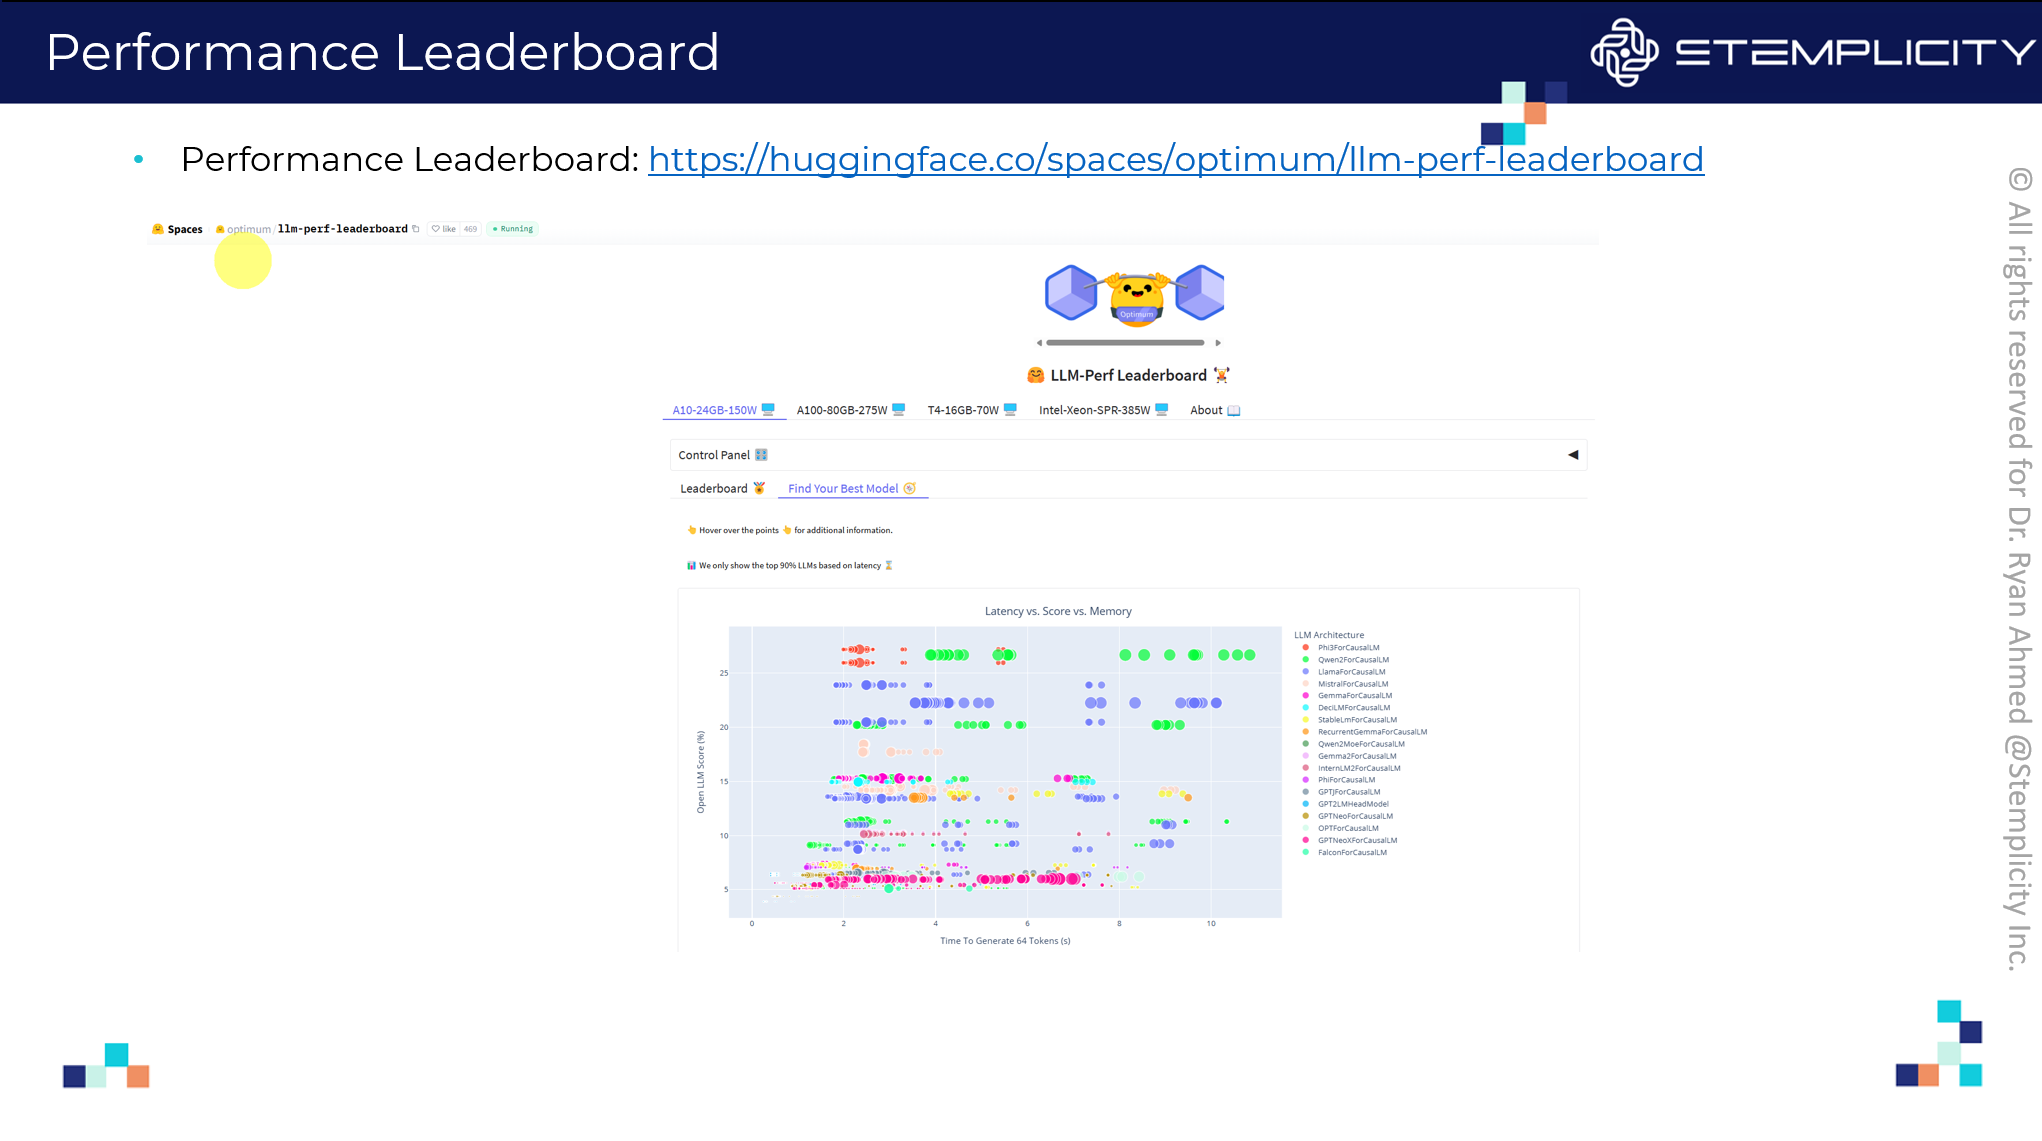

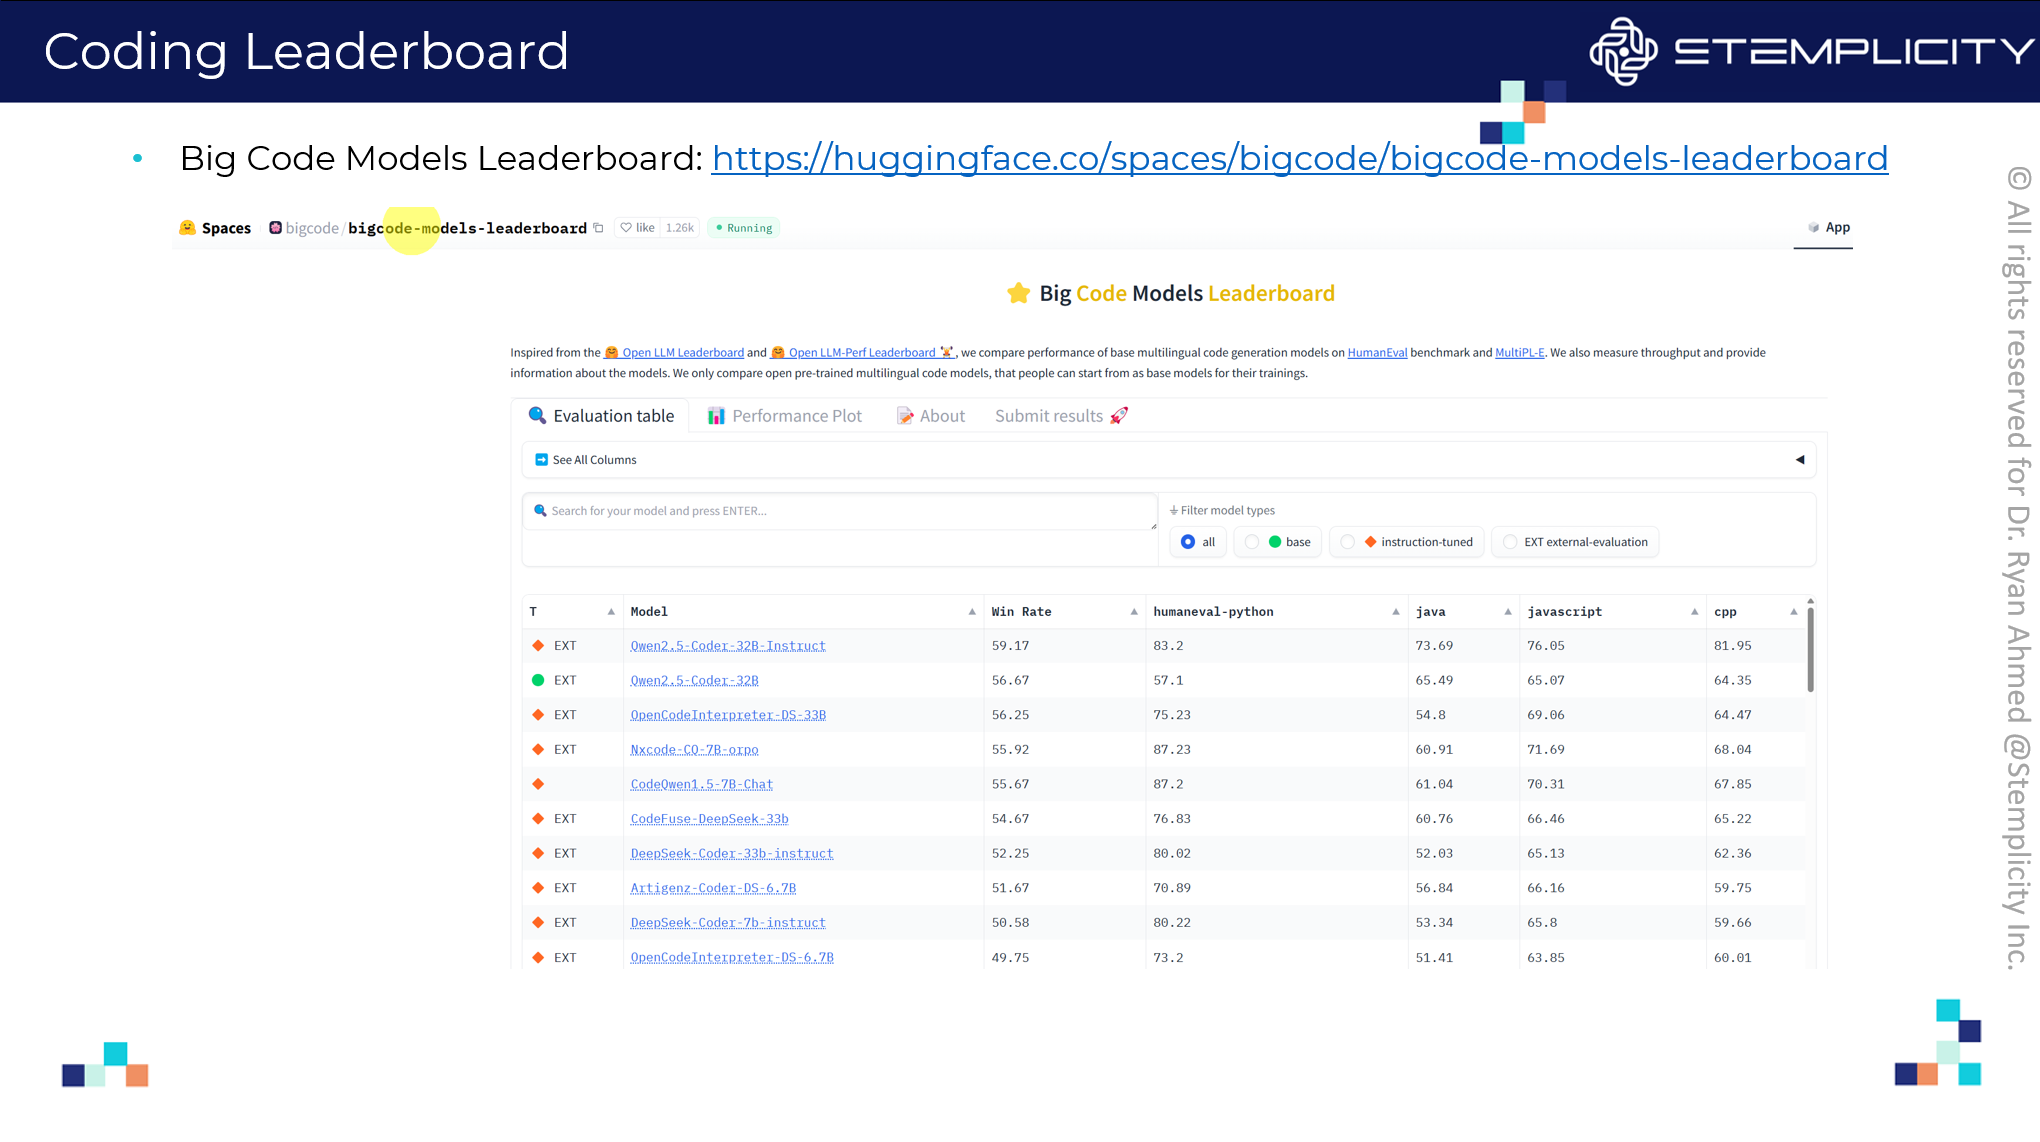

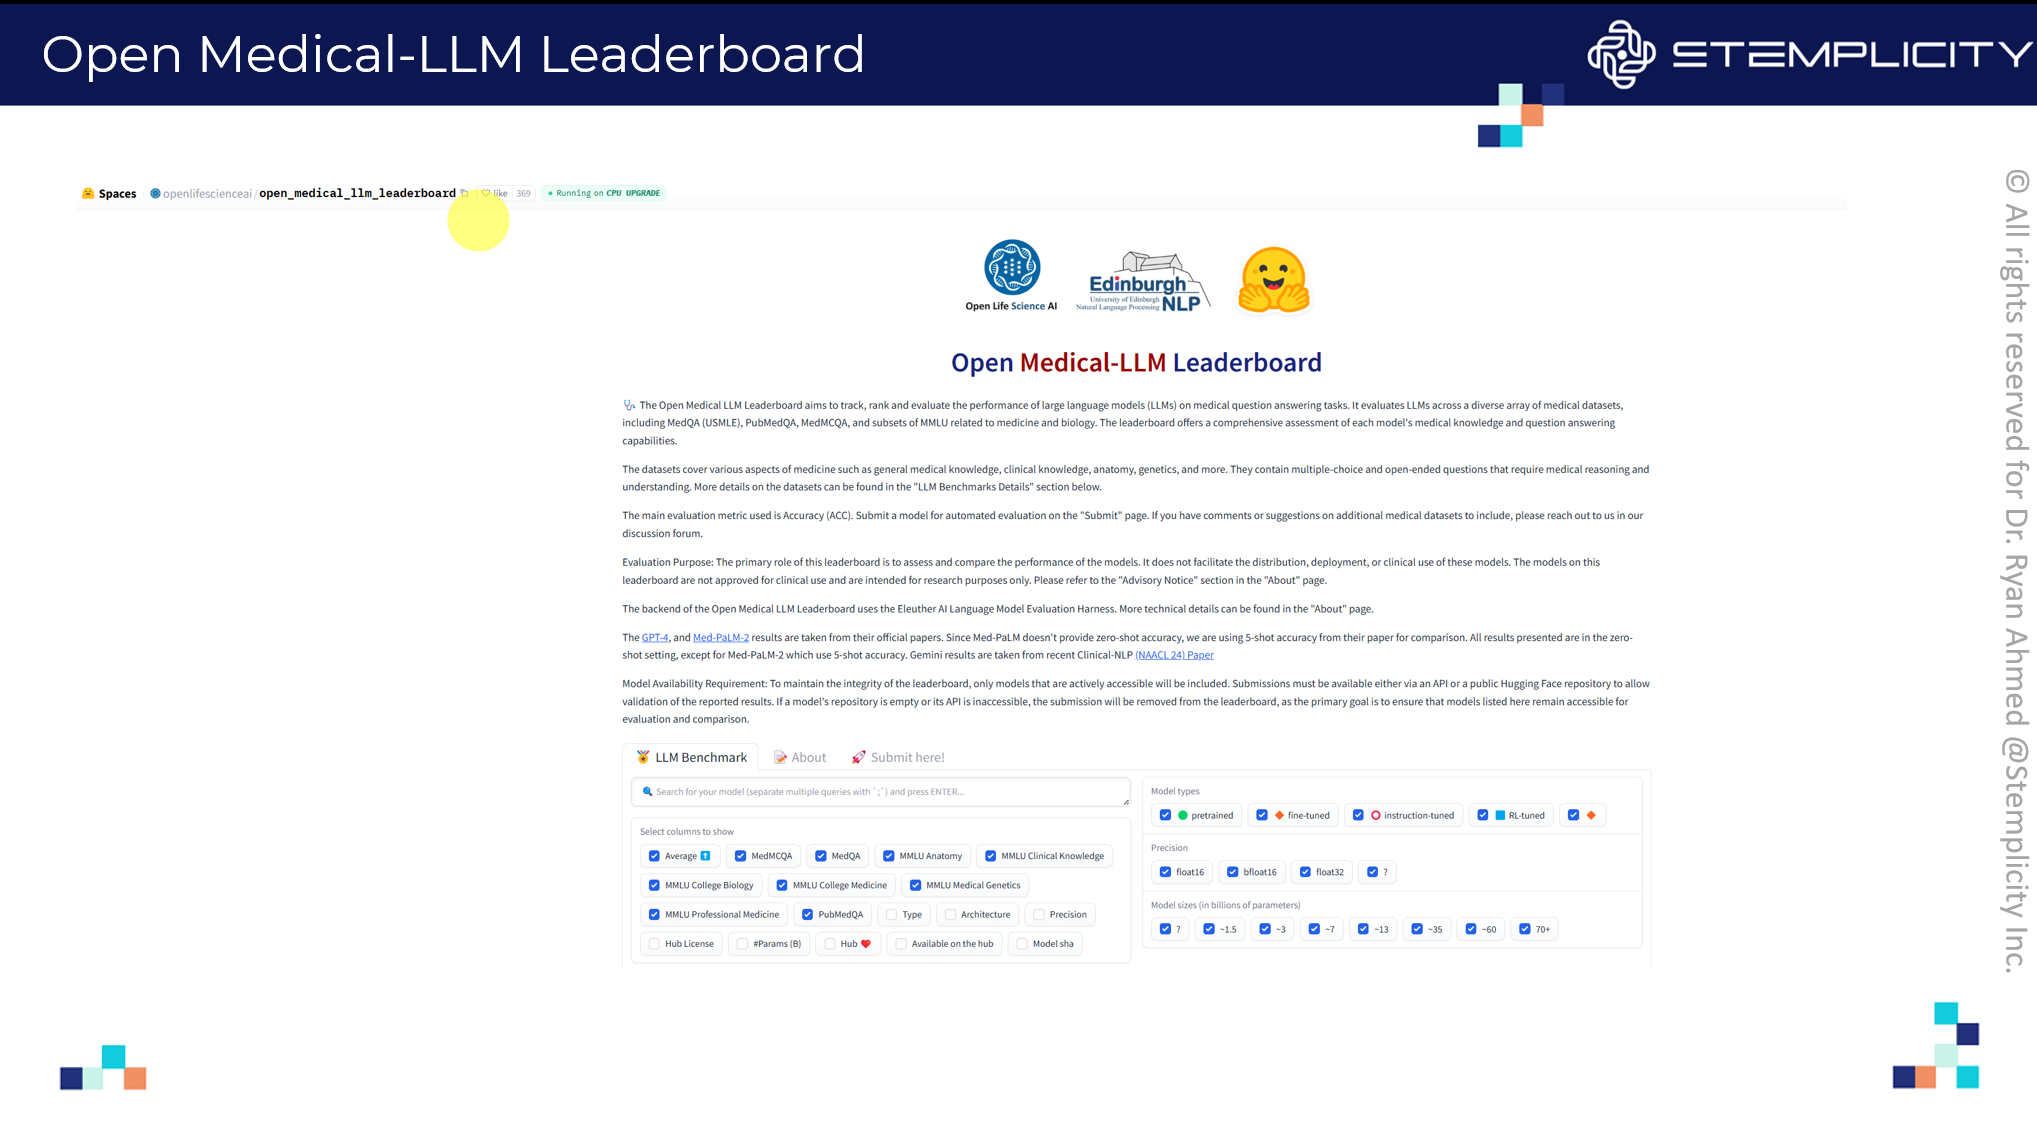

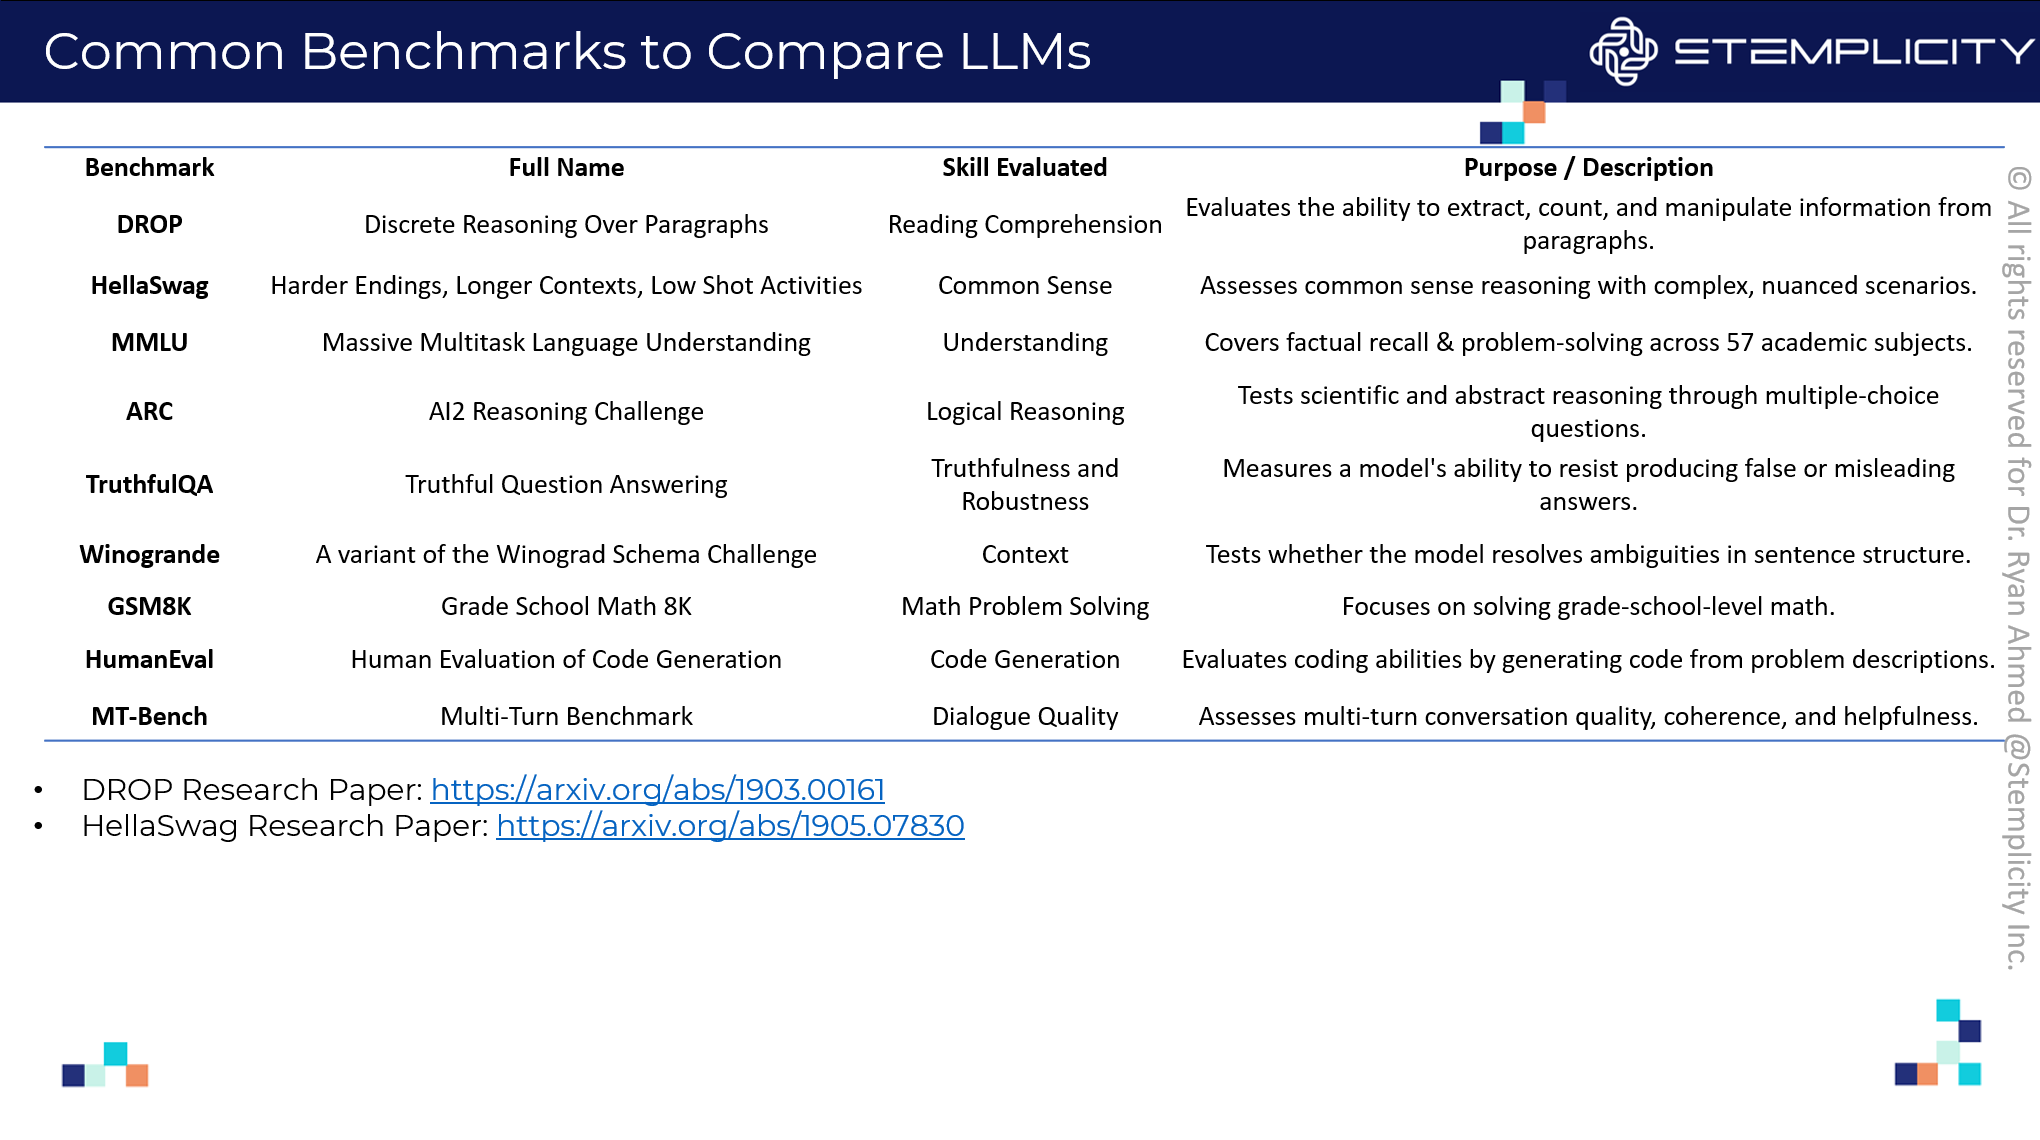

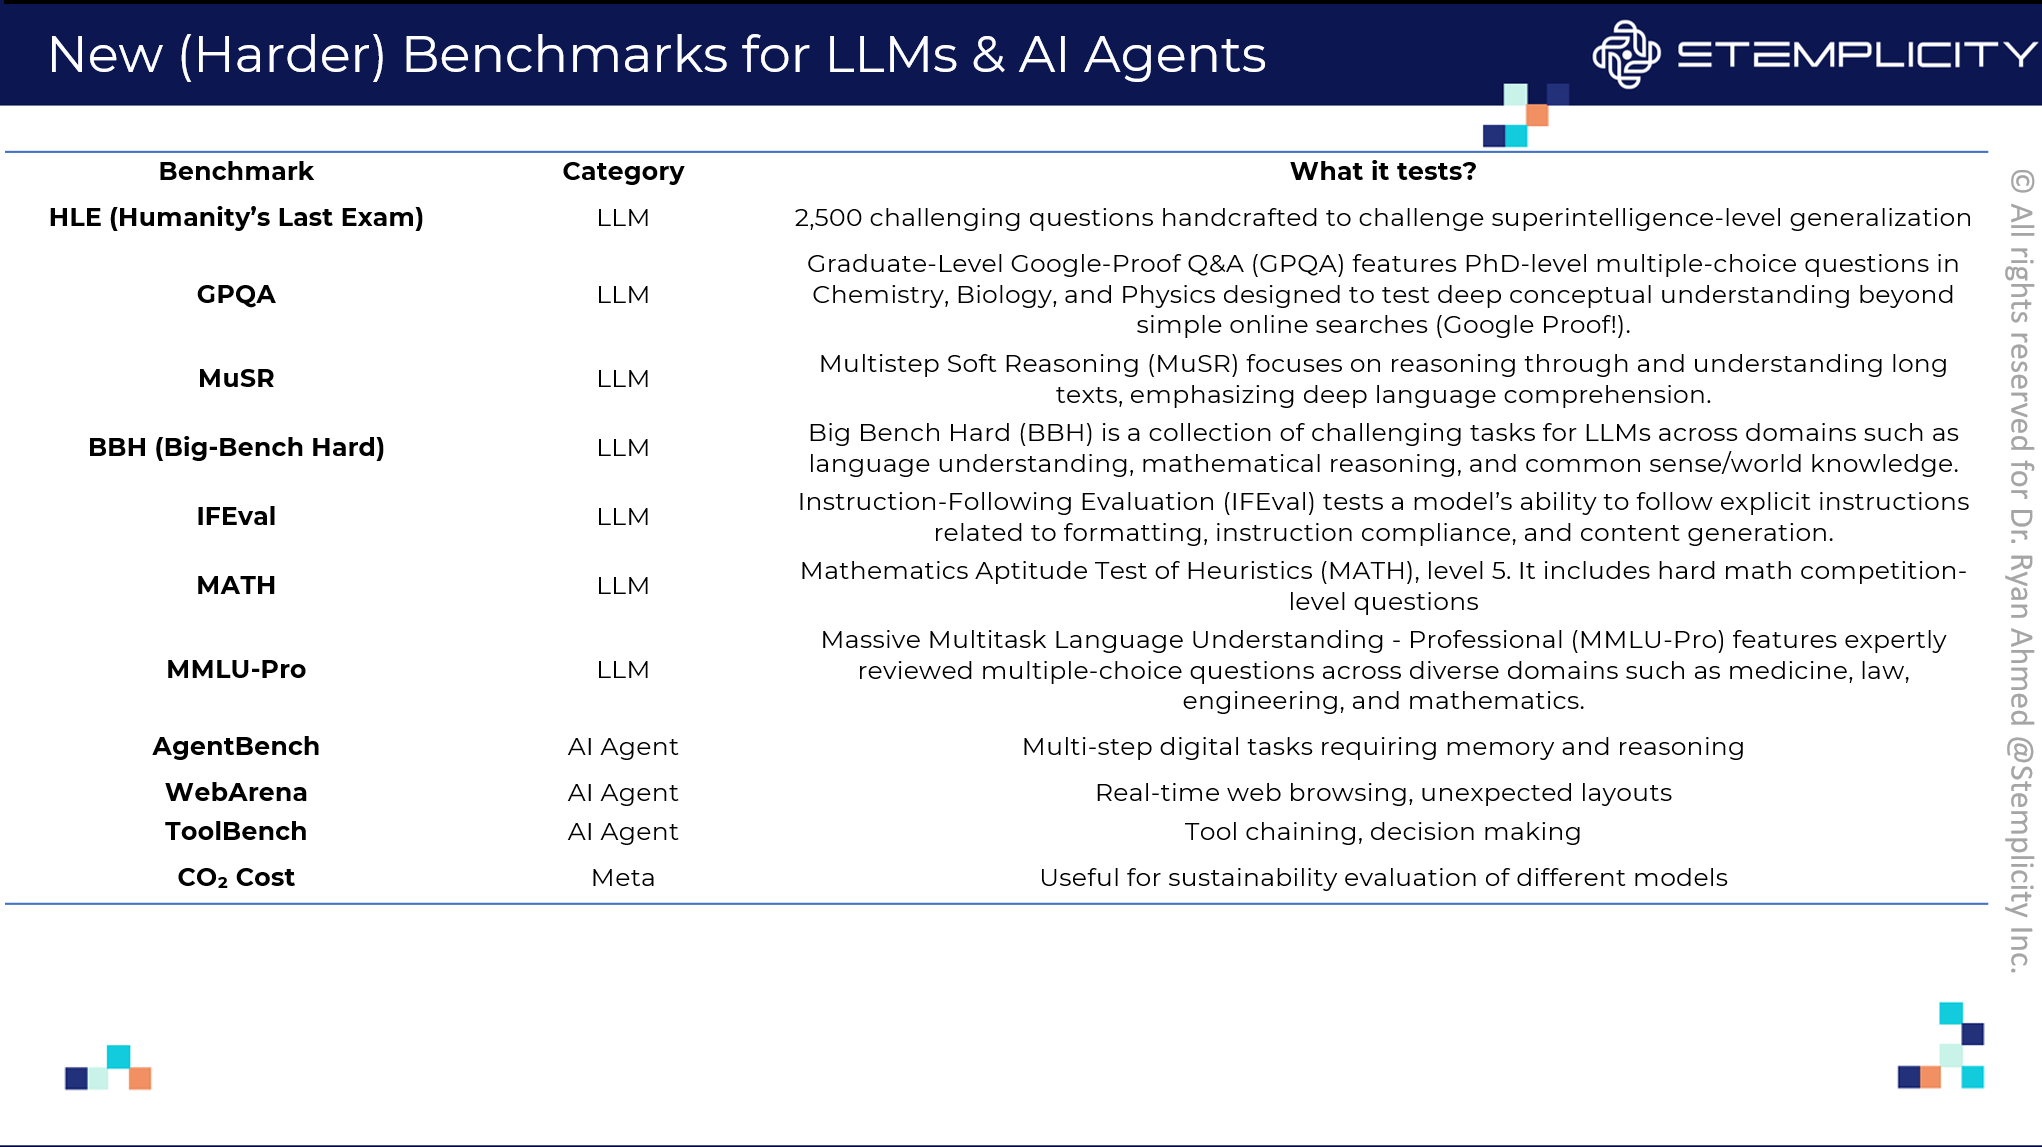

# TASK 7. PROMPTING FOR REASONING & CLASSIFICATION


This is the core of our project! We need to craft a prompt that tells the DeepSeek model exactly what we want:

1.  **Analyze** the provided financial news text (`full_text`).
2.  **Think step-by-step** from a financial perspective: why might this news be positive, negative, or neutral for the mentioned entities or the market?
3.  **Output the reasoning** clearly labeled.
4.  **Output the final classification** (one of: Positive, Negative, Neutral) clearly labeled.

Using clear labels or delimiters in the prompt helps the model structure its output, making it easier for us to parse later.

**Steps:**
1.  Define a detailed `prompt_template`.
2.  Create a function `analyze_news_sentiment` that:
    *   Takes the news text and the LLM pipeline.
    *   Formats the prompt.
    *   Calls the pipeline to generate the response.
    *   Parses the generated text to separate the reasoning from the final classification.
3.  Test the function on a few news examples.

In [ ]:
import re  # Import regular expressions for parsing

def analyze_news_sentiment(news_text, llm_pipeline):
    """
    Analyzes news sentiment using the LLM, providing reasoning and classification.

    Args:
        news_text (str): The combined title and description of the news.
        llm_pipeline (transformers.pipeline): The initialized text-generation pipeline.

    Returns:
        str: A string containing the reasoning and classification.
    """

    # Define the Prompt Template with specific instructions for the model
    test_question = f"""You are a concise Financial News Analyst.
    Analyze the provided news text. Output ONLY the three requested items below, each on a new line, prefixed with the specified label.

    1.  REASONING: Brief financial reasoning (1-2 points max) for the sentiment.
    2.  SENTIMENT: Choose ONE: Positive, Negative, Neutral.
    3.  TAG: A concise topic tag (1-3 words).

    Do NOT add any other text, greetings, or explanations.

    News Text:
    {news_text}"""

    # Format the prompt according to DeepSeek's expected input format with thinking tags
    test_prompt = f"<|im_start|>user\n{test_question}<|im_end|>\n<|im_start|>assistant\n<think>\n"

    # Print the prompt for debugging purposes to verify what's being sent to the model
    print(f"Test prompt:\n{test_prompt}")

    # Run the model inference with specific generation parameters
    outputs = llm_pipeline(
        test_prompt,
        max_new_tokens = 4000,
        do_sample = True,
        temperature = 0.7,
        top_p = 0.9)

    # Extract the full generated text and parse it to separate reasoning from classification
    # The format_model_output function likely separates the thinking process from the final answer
    full_output = outputs[0]["generated_text"]
    reason, output = format_model_output(full_output)

    # Return both the reasoning process and the final sentiment classification
    return reason, output


In [ ]:

# Print a separator line for clarity in the output
print("\n" + "=" * 30 + " TESTING ANALYSIS " + "=" * 30)


# Select a few random indices from the news dataset to test the analysis function
random_indices = random.sample(range(len(news_dataset)), 3)

# Iterate over each randomly selected index
for index in random_indices:
    # Retrieve the full text of the news item at the current index
    sample_news = news_dataset[index]["full_text"]

    # Analyze the sentiment of the sample news using the sentiment analysis function
    reason, output = analyze_news_sentiment(sample_news, llm_pipeline)

    # Print the analysis result header for the current index
    print(f"\n--- Analysis Result for Index {index} ---")

    # Display the reasoning and output in a formatted markdown style
    print_markdown(f"{reason}\n\n{output}")

    # Print a separator line for better readability between results
    print("-" * 60)



**PRACTICE OPPORTUNITY:**
- **Find an interesting news item by looking at the sample data (or pick a specific index, e.g., `index = 0`). Modify the test loop at the end of the code block above to analyze only that specific index instead of random ones. Run the cell. Do the reasoning and classification seem appropriate for that news item?**

# TASK 8. BUILDING THE GRADIO INTERFACE


Let's wrap our analysis function in a user-friendly Gradio interface. Users should be able to see a random news item and click a button to get the sentiment analysis (including reasoning).

**Interface Elements:**
*   A Textbox to display the news item (`full_text`).
*   A button to fetch a new random news item.
*   A button to trigger the analysis.
*   Two Textboxes (or Markdown elements) to display the Reasoning and the Classification separately.


In [ ]:
import gradio as gr  # Importing the Gradio library for creating the web interface
import random  # Importing the random library to generate random numbers
import re  # Importing the regular expressions library (not used in this snippet)
from transformers import pipeline  # Importing the pipeline function from transformers for model loading

# --- Gradio Helper Functions ---
def get_random_news():
    """Fetches and returns the full_text of a random news item."""
    if not news_dataset:  # Check if the news dataset is empty
        return "Error: No news items available."  # Return an error message if no news items are found
    random_index = random.randint(0, len(news_dataset) - 1)  # Generate a random index to select a news item
    news_text = news_dataset[random_index]['full_text']  # Retrieve the full text of the news item at the random index
    print(f"Fetched news item at index {random_index}")  # Print the index of the fetched news item
    return news_text  # Return the fetched news text

def perform_analysis(news_text):
    """Triggers analysis on the provided news text."""
    if not news_text or news_text.startswith("Error"):  # Check if the news text is empty or an error message
        return "Error: No news text to analyze."  # Return an error message if no valid news text is provided
    print(f"Analyzing news: {news_text[:50]}...")  # Print the first 50 characters of the news text being analyzed
    reason, output = analyze_news_sentiment(news_text, llm_pipeline)  # Analyze the sentiment of the news text
    return reason, output  # Return the reasoning and output from the analysis

# --- Build Gradio Interface ---
with gr.Blocks(theme=gr.themes.Glass()) as demo:  # Create a Gradio Blocks interface with a glass theme
    gr.Markdown("""
    # DeepSeek Financial News Analyzer
    Fetches a random news item from the dataset.
    Click 'Analyze News' to get sentiment classification and the model's reasoning.

    """)

    with gr.Row():  # Create a row for buttons
        btn_fetch = gr.Button("🔄 Fetch Random News Item")  # Button to fetch a random news item
        btn_analyze = gr.Button("💡 Analyze News", variant="primary")  # Button to analyze the news

    news_display = gr.Textbox(  # Textbox to display the news item
        label="📰 News Text (Title & Description)",  # Label for the textbox
        lines=8,  # Number of lines in the textbox
        interactive=False,  # Make the textbox non-interactive
        placeholder="Click 'Fetch Random News Item' to display news."  # Placeholder text
    )
    # Creates a collapsible panel
    with gr.Accordion("🤖 Model Reason", open=True):  # Accordion for model reasoning
        analysis_display = gr.Markdown()  # Markdown display for the reasoning

    with gr.Accordion("🤖 Model Output", open=True):  # Accordion for model output
        analysis_output = gr.Markdown()  # Markdown display for the output

    # --- Event Handlers ---
    btn_fetch.click(  # Set up click event for the fetch button
        fn=get_random_news,  # Function to call when the button is clicked
        inputs=[],  # No inputs needed
        outputs=[news_display]  # Output to the news display textbox
    )

    btn_analyze.click(  # Set up click event for the analyze button
        fn=perform_analysis,  # Function to call when the button is clicked
        inputs=[news_display],  # Input from the news display textbox
        outputs=[analysis_display, analysis_output]  # Outputs to the reasoning and output displays
    )

    # Load initial news item when the app starts
    demo.load(  # Load function to run when the app starts
        fn=get_random_news,  # Function to call to get a random news item
        inputs=None,  # No inputs needed
        outputs=[news_display]  # Output to the news display textbox
    )

# --- Launch the Gradio App ---
print("Launching Gradio demo...")  # Print message indicating the app is launching
demo.launch(debug=True)  # Launch the Gradio app in debug mode

Launching Gradio demo...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://0f963a5809ff611bf3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Fetched news item at index 2673
Fetched news item at index 3142
Fetched news item at index 2818
Analyzing news: Title: Bitcoin, Ethereum Technical Analysis: BTC B...
Test prompt:
<|im_start|>user
You are a concise Financial News Analyst.
    Analyze the provided news text. Output ONLY the three requested items below, each on a new line, prefixed with the specified label.

    1.  REASONING: Brief financial reasoning (1-2 points max) for the sentiment.
    2.  SENTIMENT: Choose ONE: Positive, Negative, Neutral.
    3.  TAG: A concise topic tag (1-3 words).

    Do NOT add any other text, greetings, or explanations.

    News Text:
    Title: Bitcoin, Ethereum Technical Analysis: BTC Back Above $21,000, Following Strong Chinese GDP Figures – Market Updates Bitcoin News
Description: Bitcoin climbed back above $21,000 on Jan. 17, as markets reacted to better-than-expected Chinese gross domestic product (GDP) figures.<|im_end|>
<|im_start|>assistant
<think>

Fetched news item at index 1781


# PRACTICE OPPORTUNITY SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:**
- **Explore the datasets section on Hugging Face, How many datasets are present?**
- **Search for News-related data, which one is the most downloaded?**
- **Search for `all_news_finance_sm_1h2023` dataset. How many samples exist?**
- **Visit the Data Studio and using AI Query Feature, select only news released by CNBC.**

In [ ]:
# Dataset size: 5062 rows × 6 columns

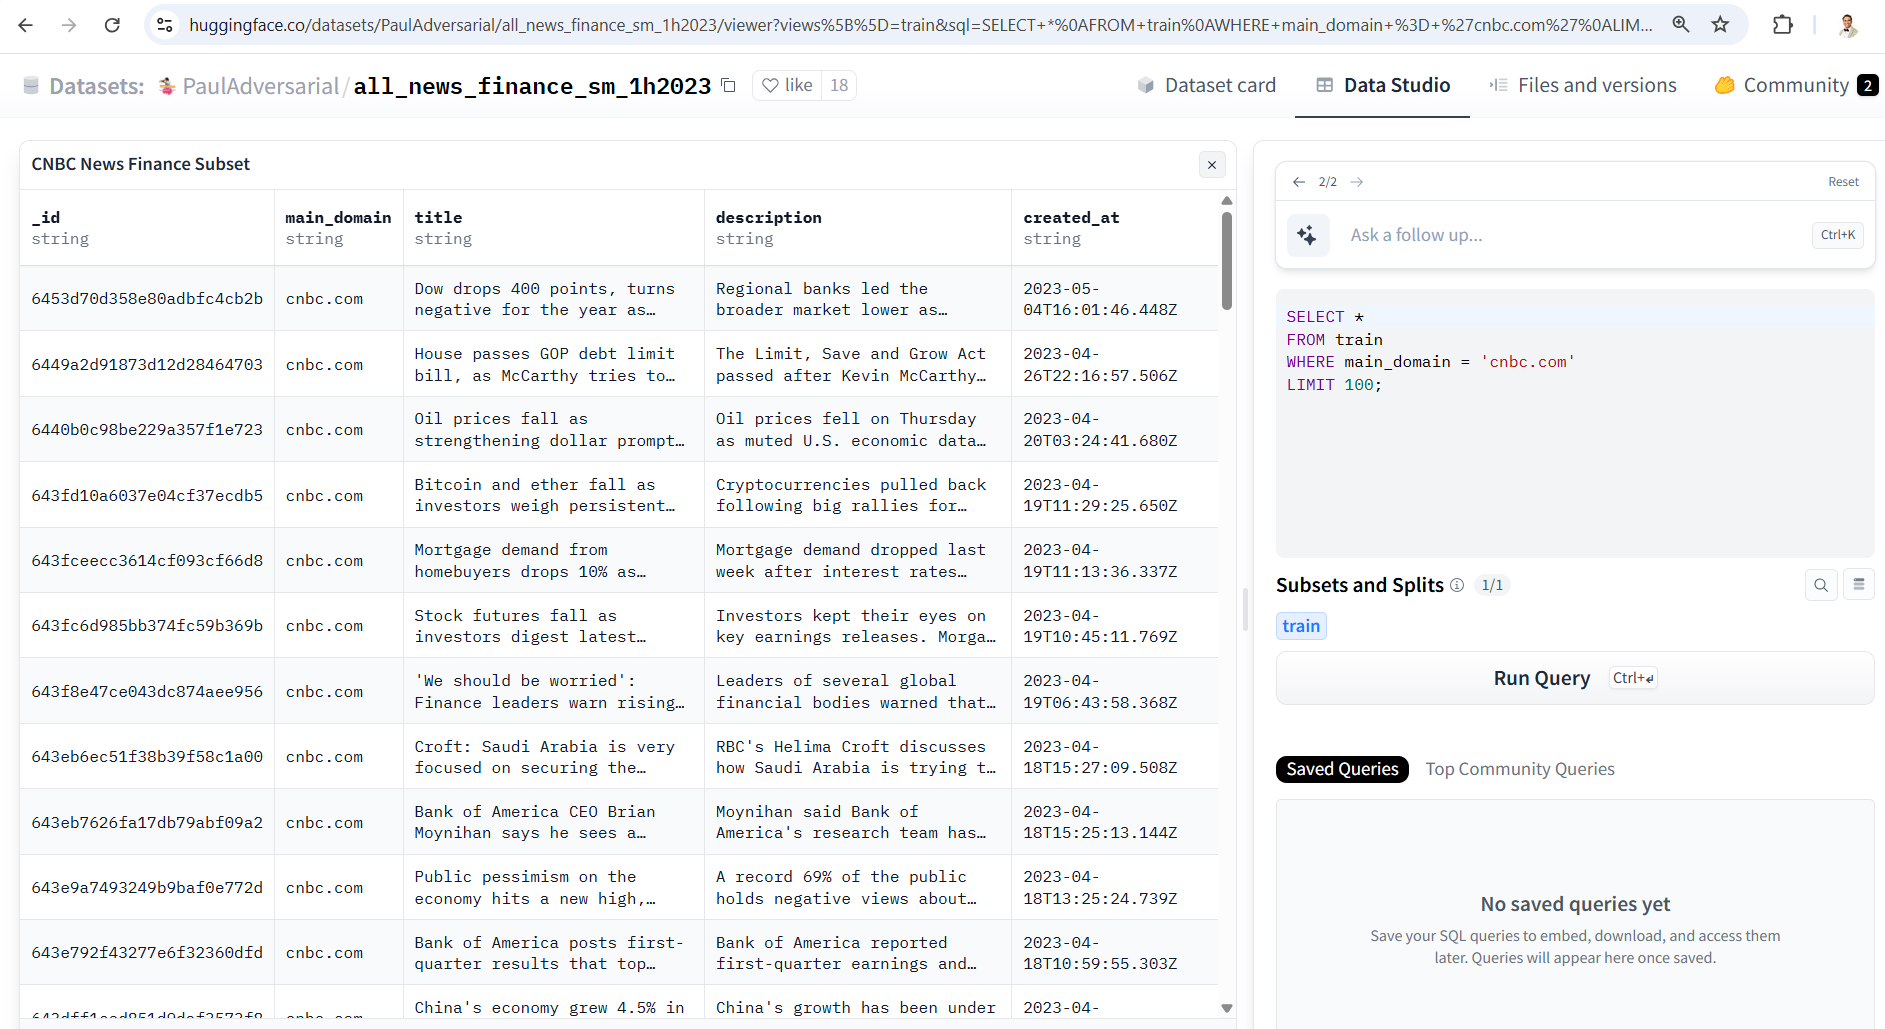

**PRACTICE OPPORTUNITY SOLUTION:**
- **Examine the "Dataset Features" output. Besides 'title' and 'description', what other potentially interesting columns are available (e.g., `main_domain`, `created_at`)?**
- **Modify the `display(...)` line in the code block to show 10 samples. Rerun the cell. Do the titles and descriptions seem relevant to financial news?**
- **How would you access only the `full_text` of the 100th news item in the dataset?**

In [ ]:
 # The "Dataset Features" output lists all columns.
 # Besides title and description, you'll see _id (string),
 # main_domain (string, e.g., 'cnbc.com'), and created_at (string, timestamp).
 # These could be used for filtering news by source or time period in more advanced analyses.

In [ ]:
# Display the first 10 samples
display(news_dataset.select(range(10)).to_pandas())

In [ ]:
# Accessing the full_text of the 100th item (index 99)
print(news_dataset[99]['full_text'])


**PRACTICE OPPORTUNITY SOLUTION:**
- **Try a very simple logic or math problem:**
    ```python
    test_question = "What is the count of apples i have now, if i initially had 5 apples with me and then gave 2 to my Mom and 2 to my brother. Keep the thining short."
```
- **Based on this simple test and the model's description, how might generating a reasoned explanation for sentiment analysis differ from just getting a conversational reply from a general chat model like we used in previous projects? What capabilities of DeepSeek R1 seem useful here?**


In [ ]:
test_question = "Is Stock X, with a beta of 1.2 and an expected return of 10.5%, undervalued or overvalued if the risk-free rate is 3% and the expected market return is 9%?"

In [ ]:
test_question = "What is the count of apples i have now, if i initially had 5 apples with me and then gave 2 to my Mom and 2 to my brother. Keep the thining short."

In [ ]:
test_prompt = f"<|im_start|>user\n{test_question}<|im_end|>\n<|im_start|>assistant\n<think>\n"
print(f"Test prompt:\n{test_prompt}")

In [ ]:
# Let's test the model with the new prompt!
print("Testing model with a simple logic")

outputs = llm_pipeline(test_prompt,
                       max_new_tokens = 4000,
                       do_sample = True,
                       temperature = 0.7,
                       top_p = 0.9)

outputs

In [ ]:
# Extract and print the generated text (only the response part)
full_output = outputs[0]["generated_text"]
reason, output = format_model_output(full_output)
print_markdown(reason + output)

- A general chat model might answer the sentiment question conversationally ("I think this news sounds negative because...") but might struggle to consistently follow a strict format requiring separate, labeled reasoning and classification sections. DeepSeek, being better at instruction following and logical structuring (due to code/math training), is more likely to adhere to the requested "Reasoning-classification" format.
- DeepSeek's strengths useful here are:
  - **Instruction Adherence:** Following the multi-part instructions in the prompt.
  - **Structured Output:** Generating text in a predictable format with delimiters.
  - **(Implied) Logical Flow:** Applying analytical steps (even if simple) to connect the news content to the sentiment, which forms the basis of the reasoning trace.


**PRACTICE OPPORTUNITY SOLUTION:**
- **Find an interesting news item by looking at the sample data (or pick a specific index, e.g., `index = 0`). Modify the test loop at the end of the code block above to analyze only that specific index instead of random ones. Run the cell. Do the reasoning and classification seem appropriate for that news item?**

In [ ]:
# In the "Sentiment Analysis Function" cell, replace the loop:
if llm_pipeline and news_dataset:
    print("\n" + "="*30 + " TESTING SENTIMENT ANALYSIS ON INDEX 70 " + "="*30)
    index_to_test = 70 # Choose the index you want to test
    if len(news_dataset) > index_to_test:
        sample_news = news_dataset[index_to_test]['full_text']
        reasoning_result, classification_result = analyze_news_sentiment(sample_news, llm_pipeline)

        print(f"\n--- Analysis Result for Index {index_to_test} ---")
        print_markdown(f"**Reasoning:**\n{reasoning_result}")
        print_markdown(f"**Classification:** {classification_result}")
        print("-"*60)
    else:
        print(f"Index {index_to_test} out of bounds.")
else:
      print("Skipping analysis test because LLM pipeline or dataset is not ready.")

- Would love to connect with you on LinkedIn: https://www.linkedin.com/in/dr-ryan-ahmed/

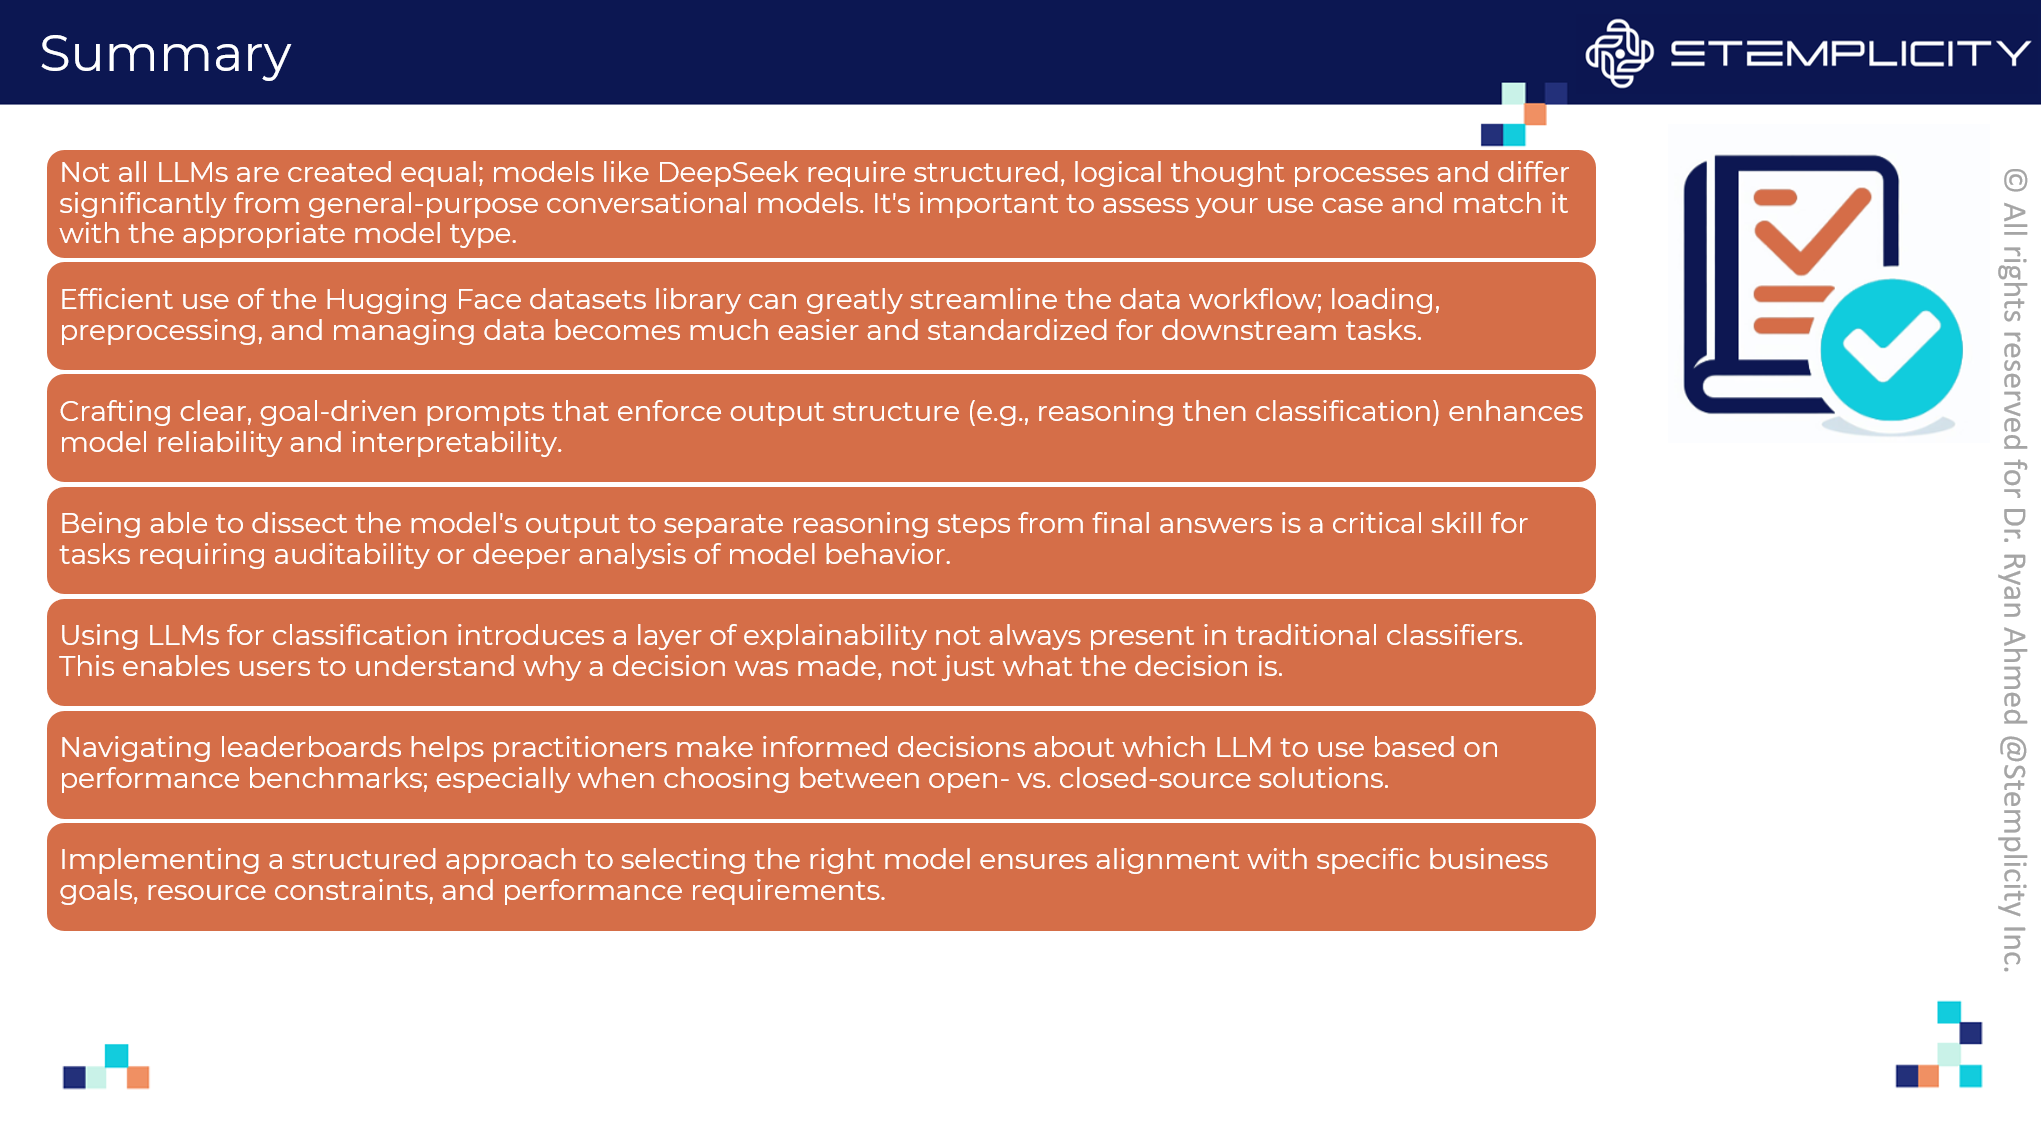

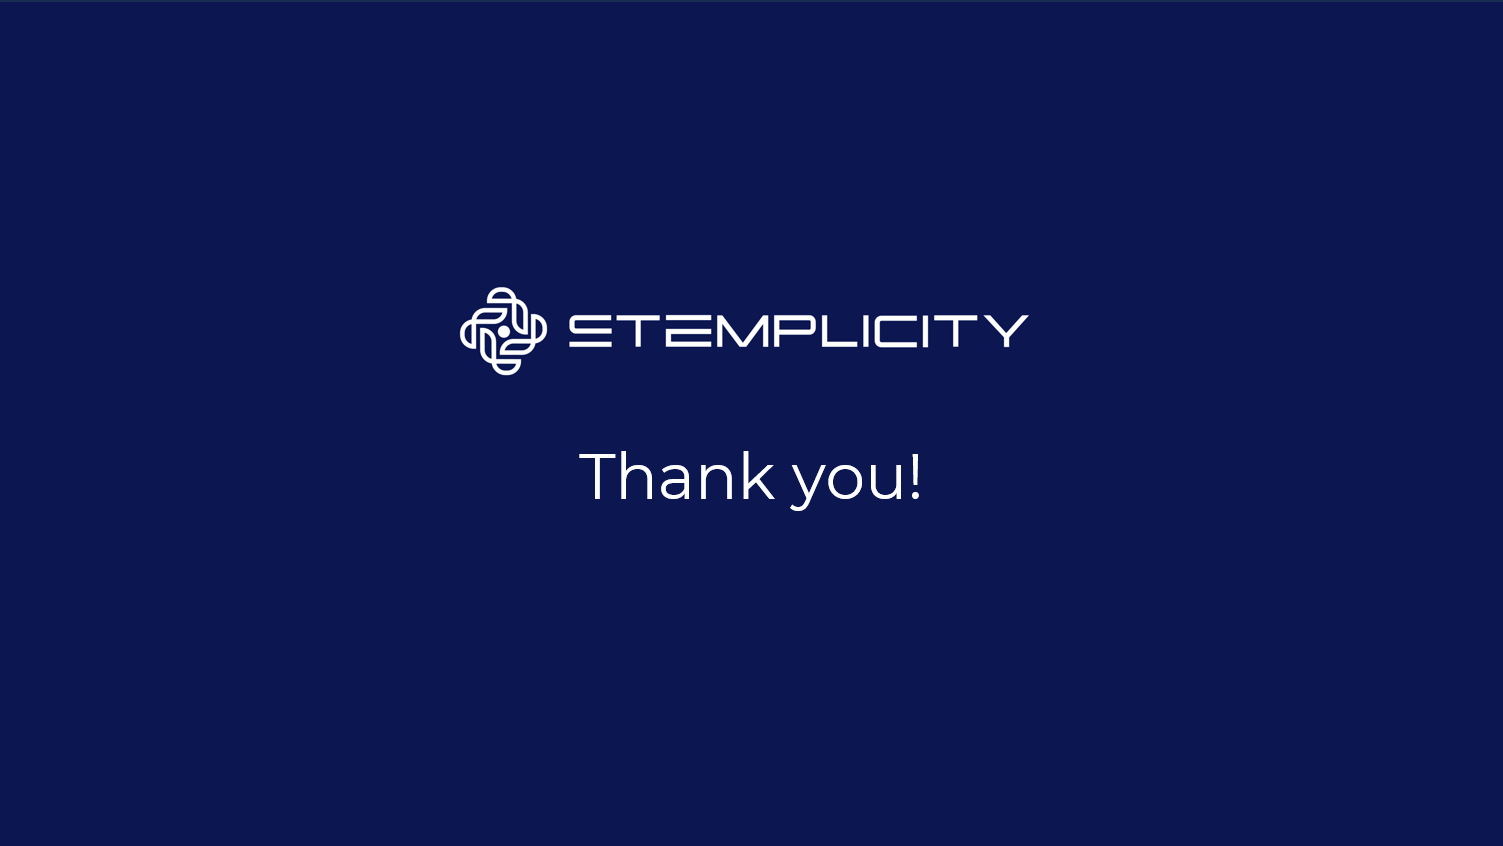